In [1]:
!pwd

/teamspace/studios/this_studio


In [2]:
my_config = {

    "ClientID": 3,

    # Local Resources
    "num_cpus": 32,
    "num_gpus": 1,

    # Higher batch size take more resources
    # 2 => 12.something GPU RAM
    "train_batch_size": 3,
    "val_batch_size": 1,
    "test_batch_size": 1,

    # Data Split
    "validation_split_per_client": 0.1,
    "test_split": 0.1,

    # FL Parameters
    "num_clients": 4,
    "epochs": 45,
    "num_rounds": 1,

    # Training Parameters
    "validation_freq": 1,
    "early_stopping_patience": 10,
}

In [3]:
import os
if "FL_PROJECT" not in os.getcwd():
    print("Dependency Installation")
    # %pip install -qqq --upgrade ipython # RUN THIS ONLY IN COLAB
    %pip install -qqq focal-loss
    %pip install -qqq "flwr[simulation]"==1.7.0
    %pip install -qqq "tensorflow[and-cuda]"==2.15.1
    %pip install -qqq opencv-python==4.8.0.76
    %pip install -qqq glob2==0.7
    %pip install -qqq numpy==1.25.2
    %pip install -qqq tqdm==4.66.2
    %pip install -qqq wandb==0.16.5
    %pip install -qqq gdown==5.1.0
    # %pip install -qqq keras_cv
    %pip install tensorflow-addons
    %pip install -qqq pickleshare
else:
    print("Dependency Already Installed")

Dependency Installation
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 24.8 MB/s eta 0:00:00

[notice] A new release of pip is available: 24.1 -> 24.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [4]:
import cv2
import glob
import json
import numpy as np
import flwr as fl
# from keras_cv.losses import FocalLoss

import matplotlib.pyplot as plt
import random
from datetime import datetime
from tqdm import tqdm
from functools import partial, lru_cache

from datetime import datetime
from sklearn.utils.class_weight import compute_class_weight


import wandb
from wandb.keras import WandbCallback, WandbMetricsLogger, WandbModelCheckpoint

import tensorflow as tf
from tensorflow.keras import models, layers, regularizers
import tensorflow.keras.backend as K

from tensorflow_addons.losses import SigmoidFocalCrossEntropy

from typing import Dict, Optional, Tuple, List, Union
from flwr.common import Metrics, NDArrays, Scalar


2024-06-29 19:32:46.256794: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-29 19:32:46.453073: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-29 19:32:46.453244: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-29 19:32:46.483108: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-29 19:32:46.566019: I tensorflow/core/platform/cpu_feature_guar

In [5]:
from flwr.simulation.ray_transport.utils import enable_tf_gpu_growth
enable_tf_gpu_growth()

2024-06-29 19:32:51.034030: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-29 19:32:51.209869: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-29 19:32:51.210137: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [6]:
os.makedirs("FL_PROJECT", exist_ok=True)
if "FL_PROJECT" not in os.getcwd():
  %cd "FL_PROJECT"

/teamspace/studios/this_studio/FL_PROJECT


In [7]:
os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'
os.environ['RAY_verbose_spill_logs'] = '0'
os.environ['WANDB_API_KEY'] = 'd6c19edee7967da9f2839441cf9c650d6e4c6559'
os.environ["RAY_memory_monitor_refresh_ms"] = "0" # To disable worker killing

wandb.login(key=os.getenv('WANDB_API_KEY'))

wandb: Currently logged in as: essawey (nu-federated-learning). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /teamspace/studios/this_studio/.netrc


True

In [8]:
tf.test.gpu_device_name(), tf.config.list_physical_devices('GPU'), tf.config.experimental.list_logical_devices('GPU')

2024-06-29 19:32:52.497143: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-29 19:32:52.497460: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-29 19:32:52.497638: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

('/device:GPU:0',
 [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')],
 [LogicalDevice(name='/device:GPU:0', device_type='GPU')])

In [9]:
# if len(tf.config.experimental.list_logical_devices('GPU')) == 0:
#   raise ValueError("NO GPU FOUND")

In [10]:
ROOT_PATH = os.getcwd()

DATA_PATH = os.path.join(ROOT_PATH, "PanNuke")

TRAIN_PATH = os.path.join(DATA_PATH, "Train")
VAL_PATH = os.path.join(DATA_PATH , "Validation")
TEST_PATH = os.path.join(DATA_PATH , "Test")

In [11]:
def getClientPath(client_id: Union[int, str], Train_Val: str) -> Tuple[str, str]:

  if not (0 <= int(client_id) <= 3):
    raise ValueError("NO CLIENT FOUND")

  client_id = str(client_id)

  if Train_Val == "Train":
    PNGs = os.path.join(DATA_PATH, "Train", client_id, "**", "*.png")
    NPYs = os.path.join(DATA_PATH, "Train", client_id, "**", "*.npy")
    return PNGs, NPYs

  if Train_Val == "Val":
    PNGs = os.path.join(DATA_PATH, "Validation", client_id, "**", "*.png")
    NPYs = os.path.join(DATA_PATH, "Validation", client_id, "**", "*.npy")
    return PNGs, NPYs

  raise ValueError("Please Select 'Train' or 'Val' as Train_Val")



In [12]:
masksLabels = [
    'Neoplastic cells',
    'Inflammatory',
    'Connective/Soft tissue cells',
    'Dead Cells',
    'Epithelial',
    'Background',
]

labels_idx = {
    0: "Neoplastic cells",
    1: "Inflammatory",
    2: "Connective/Soft tissue cells",
    3: "Dead Cells",
    4: "Epithelial",
    5: "Background"
}

numClasses = len(masksLabels)

In [13]:
def divide_datasets(
    *, datasets: list[str], num_clients: int
    ) -> dict:
  '''
  Divide a list of datasets evenly among a specified number of clients.

  Parameters:
  - datasets (list[str]): A list of dataset names or identifiers to be divided.
  - num_clients (int): The number of clients to distribute the datasets to.

  Returns:
  - client_datasets (dict): A dictionary where keys are client identifiers (e.g., 'client 1', 'client 2') and
    values are lists containing the datasets assigned to each client.
  '''
  # Calculate the number of datasets per client and the remainder
  num_datasets = len(datasets)
  datasets_per_client = num_datasets // num_clients
  remainder = num_datasets % num_clients

  client_datasets: dict = {}

  # Distribute datasets to clients
  start_idx = 0
  for client_id in range(num_clients):
    end_idx = start_idx + datasets_per_client + (1 if client_id <= remainder else 0)
    client_datasets[client_id] = datasets[start_idx:end_idx]
    start_idx = end_idx

  return client_datasets


| Client ID | Organ Name     | Local Training Samples | Local Validation Samples | Server Evaluation Samples | Percentage of the dataset |
|-----------|----------------|------------------------|--------------------------|---------------------------|---------------------------|
| Client #1 | Adrenal gland  | 350                    | 43                       | 43                        | 46.171%                   |
|           | Bile-duct      | 336                    | 42                       | 42                        |                           |
|           | Bladder        | 116                    | 15                       | 15                        |                           |
|           | Breast         | 1880                   | 236                      | 236                       |                           |
|           | Cervix         | 234                    | 30                       | 30                        |                           |
| Client #2 | Colon          | 1152                   | 144                      | 144                       | 32.983%                   |
|           | Esophagus      | 340                    | 42                       | 42                        |                           |
|           | Head Neck      | 308                    | 38                       | 38                        |                           |
|           | Kidney         | 108                    | 13                       | 13                        |                           |
|           | Liver          | 180                    | 22                       | 22                        |                           |
| Client #3 | Lung           | 148                    | 18                       | 18                        | 11.302%                   |
|           | Ovarian        | 116                    | 15                       | 15                        |                           |
|           | Pancreatic     | 156                    | 29                       | 29                        |                           |
|           | Prostate       | 145                    | 19                       | 19                        |                           |
|           | Skin           | 150                    | 18                       | 18                        |                           |
| Client #4 | Stomach        | 116                    | 15                       | 15                        | 9.543%                    |
|           | Testis         | 156                    | 20                       | 20                        |                           |
|           | Thyroid        | 180                    | 23                       | 23                        |                           |
|           | Uterus         | 148                    | 19                       | 19                        |                           |


In [14]:
if not os.path.exists(DATA_PATH):

  # FULL Data
  !gdown -O PanNuke.zip 1-lyR2TY30Y-k_Tz1gs0RK8FzojMYedsN
  !unzip -qq -o {ROOT_PATH}/"PanNuke.zip"

  # # 50% of the Data
  # !gdown -O PanNuke.zip 1-Bu7xCouEiNI0HpLyyUOktcatgVEyOXY
  # !unzip -qq -o {ROOT_PATH}/"PanNuke.zip" -d {ROOT_PATH}

  !rm {ROOT_PATH}/"PanNuke.zip"

Downloading...
From (original): https://drive.google.com/uc?id=1-lyR2TY30Y-k_Tz1gs0RK8FzojMYedsN
From (redirected): https://drive.google.com/uc?id=1-lyR2TY30Y-k_Tz1gs0RK8FzojMYedsN&confirm=t&uuid=73e9c7e7-e209-40af-9939-e0cb75fa88f6
To: /teamspace/studios/this_studio/FL_PROJECT/PanNuke.zip
100%|███████████████████████████████████████| 1.02G/1.02G [00:04<00:00, 210MB/s]


In [15]:
# Function to count PNG and NPY files recursively
def count_png_npy_pairs(dir_path):
    file_counts = {}

    # Walk through all directories and files
    for root, _, files in os.walk(dir_path):
        relative_path = os.path.relpath(root, dir_path)  # Get relative path
        png_count = sum(f.lower().endswith('.png') for f in files)
        npy_count = sum(f.lower().endswith('.npy') for f in files)
        pair_count = min(png_count, npy_count)

        file_counts[relative_path] = {
            'PNG': png_count,
            'NPY': npy_count,
            'Pairs': pair_count
        }

    return file_counts

# Generate the JSON data structure
base_dir = 'PanNuke'
data_structure = {
    category: {
        subfolder: count_png_npy_pairs(os.path.join(base_dir, category, subfolder))
        for subfolder in os.listdir(os.path.join(base_dir, category))
        if os.path.isdir(os.path.join(base_dir, category, subfolder))
    }
    for category in os.listdir(base_dir)
    if os.path.isdir(os.path.join(base_dir, category))
}

with open('metadata.json', 'w') as f:
    json.dump(data_structure, f, indent=4)

## Data Loading

#### Traning Data

In [16]:
def loadData(clientID, augmentation = True):
  images = []
  masks = []


  client_PNG, client_NPY = getClientPath(client_id=clientID, Train_Val = "Train")

  image_path_list = glob.glob(client_PNG, recursive=True)
  mask_path_list = glob.glob(client_NPY, recursive=True)

  image_path_list.sort()
  mask_path_list.sort()

  for img_path in tqdm(image_path_list, ascii=True, total = len(image_path_list), desc=f"Processing Training Images for client {clientID}"):
    img = cv2.imread(img_path,1)
    images.append(img)

  for mask_path in tqdm(mask_path_list, ascii=True, total = len(mask_path_list), desc=f"Processing Training Masks for client {clientID}"):
    mask = np.load(mask_path)
    masks.append(mask)

  images = np.array(images)
  masks = np.array(masks, dtype=np.float32)


  masks = np.transpose(masks, (0, 2, 3, 1))
  masks = binarizeChannel(masks)

  if augmentation == True:
      # Apply data augmentation techniques
      augmented_trainImages = []
      augmented_trainMasks = []

      for i in range(len(images)):
          image = images[i]
          mask = masks[i]

          image, mask = random_flip(image, mask)
          image, mask = random_rotation(image, mask)
          image, mask = random_shift(image, mask)
          image, mask = random_scale(image, mask)

          augmented_trainImages.append(image)
          augmented_trainMasks.append(mask)

      augmented_trainImages = np.array(augmented_trainImages)
      augmented_trainMasks = np.array(augmented_trainMasks)

      images = np.concatenate([images, augmented_trainImages])
      masks = np.concatenate([masks, augmented_trainMasks])

  return images, masks

#### Validation Data

In [17]:
# @title Load Validation Data
def load_val_Data(clientID):
  images = []
  masks = []

  client_PNG, client_NPY = getClientPath(client_id=clientID, Train_Val = "Val")

  image_path_list = glob.glob(client_PNG, recursive=True)
  mask_path_list = glob.glob(client_NPY, recursive=True)

  image_path_list.sort()
  mask_path_list.sort()

  for img_path in tqdm(image_path_list, ascii=True, total = len(image_path_list), desc=f"Processing Validation Images for client {clientID}"):
    img = cv2.imread(img_path,1)
    images.append(img)

  for mask_path in tqdm(mask_path_list, ascii=True, total = len(mask_path_list), desc=f"Processing Validation Masks for client {clientID}"):
    mask = np.load(mask_path)
    masks.append(mask)

  images = np.array(images)
  masks = np.array(masks, dtype=np.float32)


  masks = np.transpose(masks, (0, 2, 3, 1))
  masks = binarizeChannel(masks)

  return images, masks

#### Testing Data

In [18]:
def loadTest():

  images = []
  masks = []

  test_PNG = os.path.join(TEST_PATH, "**", "*.png")
  test_NPY = os.path.join(TEST_PATH, "**", "*.npy")

  image_path_list = glob.glob(test_PNG, recursive=True)
  mask_path_list = glob.glob(test_NPY, recursive=True)

  image_path_list.sort()
  mask_path_list.sort()

  for img_path in tqdm(image_path_list, ascii=True, total = len(image_path_list), desc="Processing Testing Images"):
    img = cv2.imread(img_path,1)
    images.append(img)

  for mask_path in tqdm(mask_path_list, ascii=True, total = len(mask_path_list), desc="Processing Testing Masks"):
    mask = np.load(mask_path)
    masks.append(mask)


  images = np.array(images)

  masks = np.array(masks, dtype=np.float32)
  masks = np.transpose(masks, (0, 2, 3, 1))
  masks = binarizeChannel(masks)

  return images, masks

### Pre-Processing

#### Masks binarization

In [19]:
def binarizeChannel(masks):

    masksNum, channels, _, _ = masks.shape

    masks_binary = np.empty_like(masks)

    # Loop through each mask and channel
    for mask_idx in range(masksNum):
        for channel_idx in range(channels):

            current_channel = masks[mask_idx, channel_idx]

            # set higher values than 1 to 1
            current_channel[current_channel > 1] = 1

            masks_binary[mask_idx, channel_idx] = current_channel

    return masks_binary

#### Data Augmentation

In [20]:
def random_flip(image, mask):
    flip_code = np.random.randint(-1, 2)
    image = cv2.flip(image, flip_code)
    mask = cv2.flip(mask, flip_code)
    return image, mask

def random_rotation(image, mask, max_angle=15):
    angle = np.random.uniform(-max_angle, max_angle)
    rows = image.shape[0]
    cols = image.shape[1]
    M = cv2.getRotationMatrix2D((cols / 2, rows / 2), angle, 1)
    image = cv2.warpAffine(image, M, (cols, rows), flags=cv2.INTER_LINEAR)
    mask = cv2.warpAffine(mask, M, (cols, rows), flags=cv2.INTER_NEAREST)
    return image, mask

def random_shift(image, mask, max_shift=0.0625):
    rows = image.shape[0]
    cols = image.shape[1]
    max_x = int(max_shift * cols)
    max_y = int(max_shift * rows)
    tx = np.random.uniform(-max_x, max_x)
    ty = np.random.uniform(-max_y, max_y)
    M = np.float32([[1, 0, tx], [0, 1, ty]])
    image = cv2.warpAffine(image, M, (cols, rows))
    mask = cv2.warpAffine(mask, M, (cols, rows), flags=cv2.INTER_NEAREST)
    return image, mask

def random_scale(image, mask, max_scale=0.5):
    scale = np.random.uniform(1 - max_scale, 1 + max_scale)
    rows = image.shape[0]
    cols = image.shape[1]
    M = cv2.getRotationMatrix2D((cols / 2, rows / 2), 0, scale)
    image = cv2.warpAffine(image, M, (cols, rows))
    mask = cv2.warpAffine(mask, M, (cols, rows), flags=cv2.INTER_NEAREST)
    return image, mask

#### Visualization

In [21]:
def plot(trainMasks, idx):
    fig, axes = plt.subplots(2, 3, figsize=(10, 6))

    channel_images = []

    for channel_index in range(trainMasks.shape[3]):

        max_value = np.max(trainMasks[idx, :, :, channel_index])

        colors = plt.cm.get_cmap('tab20', int(max_value + 1))

        row = channel_index // 3
        col = channel_index % 3

        ax = axes[row, col]
        im = ax.imshow(trainMasks[idx, :, :, channel_index], cmap=colors, vmin=0, vmax=max_value)
        ax.set_title(f'Channel {channel_index} : {list(labels_idx.values())[channel_index]}')
        ax.axis('off')
        channel_images.append(im)

    cbar_ax = fig.add_axes([0.15, -0.02, 0.7, 0.03])
    cbar = fig.colorbar(channel_images[0], cax=cbar_ax, orientation='horizontal')
    plt.tight_layout()
    plt.show()

#### Calculating class weights

In [22]:
trainImages, trainMasks = loadData(3, augmentation=False)

Processing Training Masks for client 3: 100%|##########| 608/608 [00:01<00:00, 535.63it/s]


In [23]:
# global smooth
# global smooth_list

# smooth = 100
# class_frequencies = np.sum(trainMasks, axis=(0, 1, 2))
# class_proportions = [count / np.sum(class_frequencies) for count in class_frequencies]

# # Min-max normalization to bring the values between 0 and 100
# smooth_list = [smooth / proportion for proportion in class_proportions]
# smooth_list = (smooth_list - np.min(smooth_list)) / (np.max(smooth_list) - np.min(smooth_list))

In [24]:
# Flatten the array to obtain a single list of one-hot encoded class labels for all pixels
flattened = trainMasks.reshape(-1, numClasses)

# The class labels for each pixel
class_indices = np.argmax(flattened, axis=1)

# Determine unique classes
classes = range(numClasses)

# Compute class weights based on pixel frequencies
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=classes,
    y=class_indices
)

In [25]:
# Create a dictionary mapping class indices to weights
class_weight_dict = dict(zip(classes, class_weights))

print("Class Weights:")
for class_ID, weight in class_weight_dict.items():
    print(f"Class {class_ID}: {weight}")

Class Weights:
Class 0: 1.6846158282121646
Class 1: 7.293557833357312
Class 2: 3.7749685702619256
Class 3: 155.95015342225562
Class 4: 6.5498015460113095
Class 5: 0.2063858251459112


## Model

In [26]:
# https://youtu.be/L5iV5BHkMzM

'''
Attention U-net:
https://arxiv.org/pdf/1804.03999.pdf


Note: Batch normalization should be performed over channels after a convolution,
In the following code axis is set to 3 as our inputs are of shape
[None, height, width, channel]. Channel is axis=3.

Useful blocks to build Unet

conv - BN - Activation - conv - BN - Activation - Dropout (if enabled)

'''

def conv_block(x, filter_size, size, dropout, batch_norm=False):

    conv = layers.Conv2D(size, (filter_size, filter_size), padding="same")(x)
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    conv = layers.Activation("relu")(conv)

    conv = layers.Conv2D(size, (filter_size, filter_size), padding="same")(conv)
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    conv = layers.Activation("relu")(conv)

    if dropout > 0:
        conv = layers.Dropout(dropout)(conv)

    return conv

def repeat_elem(tensor, rep):
    # lambda function to repeat Repeats the elements of a tensor along an axis
    #by a factor of rep.
    # If tensor has shape (None, 256,256,3), lambda will return a tensor of shape
    #(None, 256,256,6), if specified axis=3 and rep=2.

     return layers.Lambda(lambda x, repnum: K.repeat_elements(x, repnum, axis=3),
                          arguments={'repnum': rep})(tensor)

def res_conv_block(x, filter_size, size, dropout, batch_norm=False):
    '''
    Residual convolutional layer.
    Two variants....
    Either put activation function before the addition with shortcut
    or after the addition (which would be as proposed in the original resNet).

    1. conv - BN - Activation - conv - BN - Activation
                                          - shortcut  - BN - shortcut+BN

    2. conv - BN - Activation - conv - BN
                                     - shortcut  - BN - shortcut+BN - Activation

    Check fig 4 in https://arxiv.org/ftp/arxiv/papers/1802/1802.06955.pdf
    '''

    conv = layers.Conv2D(size, (filter_size, filter_size), padding='same')(x)
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    conv = layers.Activation('relu')(conv)

    conv = layers.Conv2D(size, (filter_size, filter_size), padding='same')(conv)
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    #conv = layers.Activation('relu')(conv)    #Activation before addition with shortcut
    if dropout > 0:
        conv = layers.Dropout(dropout)(conv)

    shortcut = layers.Conv2D(size, kernel_size=(1, 1), padding='same')(x)
    if batch_norm is True:
        shortcut = layers.BatchNormalization(axis=3)(shortcut)

    res_path = layers.add([shortcut, conv])
    res_path = layers.Activation('relu')(res_path)  #Activation after addition with shortcut (Original residual block)
    return res_path

def gating_signal(input, out_size, batch_norm=False):
    """
    resize the down layer feature map into the same dimension as the up layer feature map
    using 1x1 conv
    :return: the gating feature map with the same dimension of the up layer feature map
    """
    x = layers.Conv2D(out_size, (1, 1), padding='same')(input)
    if batch_norm:
        x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    return x

def attention_block(x, gating, inter_shape):
    shape_x = K.int_shape(x)
    shape_g = K.int_shape(gating)

    # Getting the x signal to the same shape as the gating signal
    theta_x = layers.Conv2D(inter_shape, (2, 2), strides=(2, 2), padding='same')(x)  # 16
    shape_theta_x = K.int_shape(theta_x)

    # Getting the gating signal to the same number of filters as the inter_shape
    phi_g = layers.Conv2D(inter_shape, (1, 1), padding='same')(gating)
    upsample_g = layers.Conv2DTranspose(inter_shape, (3, 3),
                                 strides=(shape_theta_x[1] // shape_g[1], shape_theta_x[2] // shape_g[2]),
                                 padding='same')(phi_g)  # 16

    concat_xg = layers.add([upsample_g, theta_x])
    act_xg = layers.Activation('relu')(concat_xg)
    psi = layers.Conv2D(1, (1, 1), padding='same')(act_xg)
    sigmoid_xg = layers.Activation('sigmoid')(psi)
    shape_sigmoid = K.int_shape(sigmoid_xg)
    upsample_psi = layers.UpSampling2D(size=(shape_x[1] // shape_sigmoid[1], shape_x[2] // shape_sigmoid[2]))(sigmoid_xg)  # 32

    upsample_psi = repeat_elem(upsample_psi, shape_x[3])

    y = layers.multiply([upsample_psi, x])

    result = layers.Conv2D(shape_x[3], (1, 1), padding='same')(y)
    result_bn = layers.BatchNormalization()(result)
    return result_bn

def CNN(input_shape=(256,256,3), NUM_CLASSES=6, dropout_rate=0.2, batch_norm=True):
    '''
    Rsidual UNet, with attention
    '''
    # network structure
    FILTER_NUM = 64 # number of basic filters for the first layer
    FILTER_SIZE = 3 # size of the convolutional filter
    UP_SAMP_SIZE = 2 # size of upsampling filters
    # input data
    # dimension of the image depth
    inputs = layers.Input(input_shape, dtype=tf.float32)
    axis = 3

    # Downsampling layers
    # DownRes 1, double residual convolution + pooling
    conv_128 = res_conv_block(inputs, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)
    pool_64 = layers.MaxPooling2D(pool_size=(2,2))(conv_128)
    # DownRes 2
    conv_64 = res_conv_block(pool_64, FILTER_SIZE, 2*FILTER_NUM, dropout_rate, batch_norm)
    pool_32 = layers.MaxPooling2D(pool_size=(2,2))(conv_64)
    # DownRes 3
    conv_32 = res_conv_block(pool_32, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, batch_norm)
    pool_16 = layers.MaxPooling2D(pool_size=(2,2))(conv_32)
    # DownRes 4
    conv_16 = res_conv_block(pool_16, FILTER_SIZE, 8*FILTER_NUM, dropout_rate, batch_norm)
    pool_8 = layers.MaxPooling2D(pool_size=(2,2))(conv_16)
    # DownRes 5, convolution only
    conv_8 = res_conv_block(pool_8, FILTER_SIZE, 16*FILTER_NUM, dropout_rate, batch_norm)

    # Upsampling layers
    # UpRes 6, attention gated concatenation + upsampling + double residual convolution
    gating_16 = gating_signal(conv_8, 8*FILTER_NUM, batch_norm)
    att_16 = attention_block(conv_16, gating_16, 8*FILTER_NUM)
    up_16 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(conv_8)
    up_16 = layers.concatenate([up_16, att_16], axis=axis)
    up_conv_16 = res_conv_block(up_16, FILTER_SIZE, 8*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 7
    gating_32 = gating_signal(up_conv_16, 4*FILTER_NUM, batch_norm)
    att_32 = attention_block(conv_32, gating_32, 4*FILTER_NUM)
    up_32 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_16)
    up_32 = layers.concatenate([up_32, att_32], axis=axis)
    up_conv_32 = res_conv_block(up_32, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 8
    gating_64 = gating_signal(up_conv_32, 2*FILTER_NUM, batch_norm)
    att_64 = attention_block(conv_64, gating_64, 2*FILTER_NUM)
    up_64 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_32)
    up_64 = layers.concatenate([up_64, att_64], axis=axis)
    up_conv_64 = res_conv_block(up_64, FILTER_SIZE, 2*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 9
    gating_128 = gating_signal(up_conv_64, FILTER_NUM, batch_norm)
    att_128 = attention_block(conv_128, gating_128, FILTER_NUM)
    up_128 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_64)
    up_128 = layers.concatenate([up_128, att_128], axis=axis)
    up_conv_128 = res_conv_block(up_128, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)

    # 1*1 convolutional layers

    conv_final = layers.Conv2D(NUM_CLASSES, kernel_size=(1,1))(up_conv_128)
    conv_final = layers.BatchNormalization(axis=axis)(conv_final)
    conv_final = layers.Activation('softmax')(conv_final)

    # Model integration
    model = models.Model(inputs, conv_final, name="AttentionResUNet")
    return model

### Loss Functions

In [27]:
from tensorflow_addons.losses import SigmoidFocalCrossEntropy


class WeightedLoss(tf.keras.losses.Loss):
    def __init__(self, class_weights = class_weight_dict, alpha=0.25, gamma=2, name='WeightedLoss'):
        super().__init__(name=name)
        self.class_weights = tf.constant(list(class_weights.values()), dtype=tf.float32)
        self.smooth = K.epsilon()

        self.alpha = alpha
        self.gamma = gamma


    def DiceLoss(self, y_true, y_pred):

        # Calculate intersection and union
        intersection = K.sum(self.class_weights * y_true * y_pred)
        union = K.sum(self.class_weights * (y_true + y_pred))

        # Calculate Dice coefficient
        dice_coeff = (2. * intersection + self.smooth) / (union + self.smooth)

        # Calculate Dice loss
        return 1 - dice_coeff

    def IoULoss(self, y_true, y_pred):

        # Calculate intersection and union
        intersection = K.sum(self.class_weights * y_true * y_pred)
        union = K.sum(self.class_weights * (y_true + y_pred)) - intersection

        # Calculate IoU
        iou_coeff = (intersection + self.smooth) / (union + self.smooth)

        # Calculate Dice loss
        return 1 - iou_coeff


    def FocalLoss(self, y_true, y_pred):
        # Use SigmoidFocalCrossEntropy from TensorFlow Addons
        focal_loss = SigmoidFocalCrossEntropy(alpha=self.alpha, gamma=self.gamma)
        return tf.reduce_mean(focal_loss(y_true, y_pred))

    def CategoricalFocalCrossentropyLoss(self, y_true, y_pred):
        return tf.keras.losses.categorical_focal_crossentropy(y_true, y_pred, alpha = self.class_weights, gamma = self.gamma)

    def call(self, y_true, y_pred):
        return \
            tf.cast(1/1, tf.float64) * tf.cast(self.DiceLoss(y_true, y_pred), tf.float64) + \
            tf.cast(0/4, tf.float64) * tf.cast(self.FocalLoss(y_true, y_pred), tf.float64) + \
            tf.cast(0/2, tf.float64) * tf.cast(self.CategoricalFocalCrossentropyLoss(y_true, y_pred), tf.float64)

#### Recall

In [28]:
# @tf.autograph.experimental.do_not_convert
# def recall(y_true, y_pred) -> float:
#     """
#     Recall metric.
#     Only computes a batch-wise average of recall.
#     Computes the recall, a metric for multi-label classification of
#     how many relevant items are selected.
#     """

#     y_pred = K.clip(K.round(y_pred), K.epsilon(), 1 - K.epsilon())
#     y_true = K.clip(K.round(y_true), K.epsilon(), 1 - K.epsilon())

#     true_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_true * y_pred * class_weights, 0, 1)))
#     possible_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_true, 0, 1)))
#     recall_value = true_positives / (possible_positives + K.epsilon())
#     return recall_value


# @tf.autograph.experimental.do_not_convert
# def recall_multilabel(y_true, y_pred):
#     recall_value = 0
#     for index in range(numClasses):
#          recall_value += recall(y_true[:,:,:,index], y_pred[:,:,:,index])
#     return recall_value / 6



#### Precision

In [29]:
# @tf.autograph.experimental.do_not_convert
# def precision(y_true, y_pred) -> float:
#     """Precision metric.
#     Only computes a batch-wise average of precision.
#     Computes the precision, a metric for multi-label classification of
#     how many selected items are relevant.
#     """

#     y_pred = K.clip(K.round(y_pred), K.epsilon(), 1 - K.epsilon())
#     y_true = K.clip(K.round(y_true), K.epsilon(), 1 - K.epsilon())

#     true_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_true * y_pred * class_weights, 0, 1)))
#     predicted_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_pred, 0, 1)))
#     precision_value = true_positives / (predicted_positives + K.epsilon())
#     return precision_value


# @tf.autograph.experimental.do_not_convert
# def precision_multilabel(y_true, y_pred):
#     precision_value = 0
#     for index in range(numClasses):
#          precision_value += precision(y_true[:,:,:,index], y_pred[:,:,:,index])
#     return precision_value / 6


#### Custom Metrics

In [30]:
loss_func = WeightedLoss()

In [31]:
custom_metrics = [
    'accuracy',

    tf.keras.metrics.OneHotMeanIoU(
        num_classes=numClasses,
        name="tf_OneHotMeanIoU"
    ),

    tf.keras.metrics.OneHotIoU(
        num_classes=numClasses,
        target_class_ids=list(range(numClasses)),
        name="tf_OneHotIoU"
    ),

    tf.keras.metrics.MeanIoU(
        num_classes=numClasses,
        name="tf_MeanIoU"
    ),

    loss_func.DiceLoss,
    loss_func.IoULoss,
    loss_func.FocalLoss,
    loss_func.CategoricalFocalCrossentropyLoss,

    tf.keras.losses.CategoricalCrossentropy(name='tf_CategoricalCrossentropy'),

]

### Model

In [32]:
# tf.experimental.numpy.experimental_enable_numpy_behavior()

In [33]:
from keras.callbacks import EarlyStopping

early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=my_config['early_stopping_patience'],
    restore_best_weights=True,
)

### Custom Classes

In [34]:
from tensorflow.keras.utils import Sequence
# keras.utils.PyDataset
class DataGenerator(Sequence):
    def __init__(self, data, batch_size):
        self.x, self.y = data
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        return batch_x, batch_y

In [35]:
# Define a custom callback class to capture and save log messages
class LogCaptureCallback(tf.keras.callbacks.Callback):
    def __init__(self, file_path):
        super().__init__()
        self.file_path = file_path
        self.epoch_logs = []  # Store logs for each epoch in a list

    def on_epoch_end(self, epoch, logs=None):
        # Create a dictionary to store the logs for this epoch
        epoch_log = {"epoch": epoch + 1}
        if logs:
            epoch_log.update(logs)

        # Add the epoch's logs to the list
        self.epoch_logs.append(epoch_log)

        # Write the complete list to the JSON file
        with open(self.file_path, 'w') as json_file:
            json.dump(self.epoch_logs, json_file, indent=4)

### System Mounting

In [36]:
!nvidia-smi

Sat Jun 29 19:35:14 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.183.01             Driver Version: 535.183.01   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:1E.0 Off |                    0 |
| N/A   42C    P0              33W /  70W |    135MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [37]:
import sys
def sizeof_fmt(num, suffix='B'):
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

for name, size in sorted(((name, sys.getsizeof(value)) for name, value in list(
                          locals().items())), key= lambda x: -x[1])[:10]:
    print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))

                    trainMasks: 912.0 MiB
                 class_indices: 304.0 MiB
                   trainImages: 114.0 MiB
                          _i26:  7.8 KiB
                          _i27:  2.0 KiB
                          tqdm:  2.0 KiB
                          _i16:  1.7 KiB
                 EarlyStopping:  1.4 KiB
                          _i20:  1.4 KiB
                  WeightedLoss:  1.2 KiB


### Start Run


In [38]:
model = CNN()

In [39]:
from tensorflow.keras.optimizers import Adam

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss=loss_func,
    metrics=[custom_metrics],
)

In [40]:
# wandb.init(project=f"FINAL=RUN=C={my_config['ClientID']}", entity="essawey",config=my_config)

In [41]:
history = model.fit(
    DataGenerator(loadData(my_config['ClientID']), my_config['train_batch_size']),

    epochs=my_config['epochs'],

    validation_data=DataGenerator(load_val_Data(my_config['ClientID']), my_config['val_batch_size']),

    validation_freq=my_config['validation_freq'],

    validation_steps=my_config['val_batch_size'],

    verbose=1,

    callbacks=[
        early_stopping_callback,
        # WandbCallback(),
        # WandbMetricsLogger(log_freq = 'batch'),
        LogCaptureCallback(f"client #{my_config['ClientID']} model log={datetime.now().strftime('%Y-%m-%d=%H:%M:%S')}.json")
        ]
    )

Processing Validation Masks for client 3: 100%|##########| 73/73 [00:01<00:00, 54.97it/s]


Epoch 1/45


2024-06-29 19:35:44.084900: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inAttentionResUNet/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-06-29 19:35:46.930034: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-06-29 19:35:56.817170: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fe652306070 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-06-29 19:35:56.817211: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2024-06-29 19:35:56.854211: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1719689757.036108    3698 device_compiler.h:186] Compiled cluster using XLA!  This 

406/406 [==============================] - 215s 407ms/step - loss: 0.9628 - accuracy: 0.4681 - tf_OneHotMeanIoU: 0.1440 - tf_OneHotIoU: 0.1440 - tf_MeanIoU: 0.4274 - DiceLoss: 0.9628 - IoULoss: 0.9809 - FocalLoss: 0.6826 - CategoricalFocalCrossentropyLoss: 1.8393 - tf_CategoricalCrossentropy: 1.6411 - val_loss: 0.9228 - val_accuracy: 0.9733 - val_tf_OneHotMeanIoU: 0.8224 - val_tf_OneHotIoU: 0.8224 - val_tf_MeanIoU: 0.4167 - val_DiceLoss: 0.9228 - val_IoULoss: 0.9598 - val_FocalLoss: 0.0456 - val_CategoricalFocalCrossentropyLoss: 0.1412 - val_tf_CategoricalCrossentropy: 0.4872
Epoch 2/45
406/406 [==============================] - 154s 380ms/step - loss: 0.8999 - accuracy: 0.5803 - tf_OneHotMeanIoU: 0.1959 - tf_OneHotIoU: 0.1959 - tf_MeanIoU: 0.4274 - DiceLoss: 0.9000 - IoULoss: 0.9466 - FocalLoss: 1.0864 - CategoricalFocalCrossentropyLoss: 2.4812 - tf_CategoricalCrossentropy: 1.7661 - val_loss: 0.7309 - val_accuracy: 0.9772 - val_tf_OneHotMeanIoU: 0.8519 - val_tf_OneHotIoU: 0.8519 - val

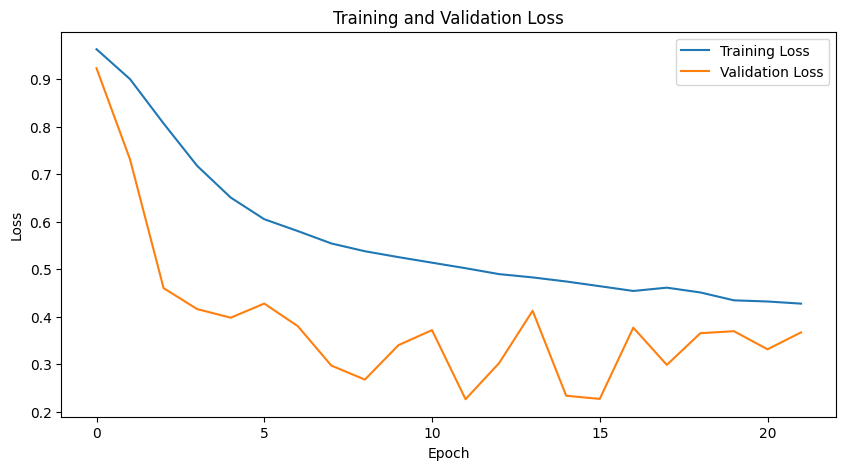

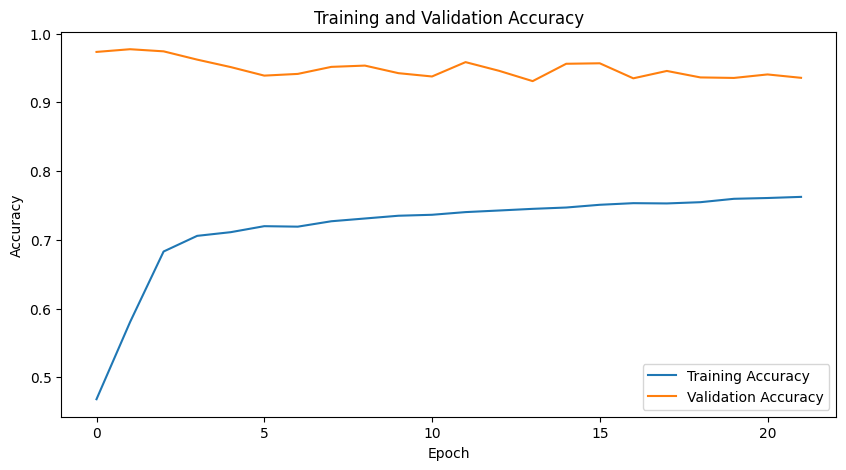

In [42]:
plt.figure(figsize=(10, 5))
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Training and Validation Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(history.history["accuracy"], label="Training Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend()
plt.show()

## Results

In [53]:
loss_function = WeightedLoss()

In [54]:
WeightedLoss()
def predict(images, target, model, idx):
    prediction = model.predict(images)
    prediction = tf.round(prediction)
    plot(target,idx)
    plot(prediction,idx)
    print(f'IoU: {loss_function.IoULoss(target,prediction)}')
    print(f'Dice: {loss_function.DiceLoss(target,prediction)}')
    print(f'FocalLoss: {loss_function.FocalLoss(target,prediction)}')
    print("="*120)

### Train Results

In [55]:
trainImages, trainMasks = loadData(my_config['ClientID'], augmentation = False)

Processing Training Masks for client 3: 100%|##########| 608/608 [00:03<00:00, 196.24it/s]


19/19 [==============================] - 13s 729ms/step


/tmp/ipykernel_3351/2983828874.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20', int(max_value + 1))
/tmp/ipykernel_3351/2983828874.py:23: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


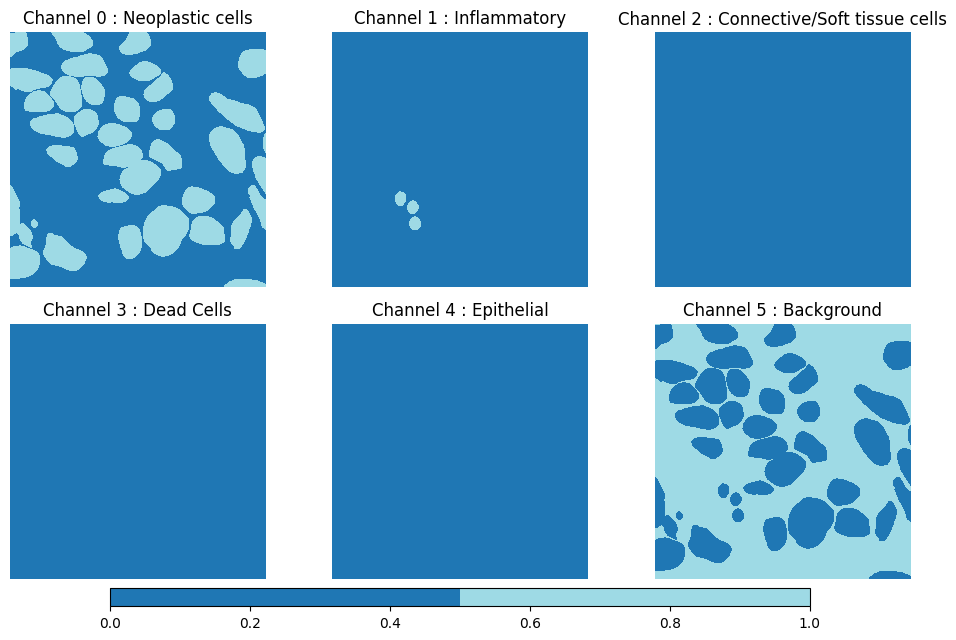

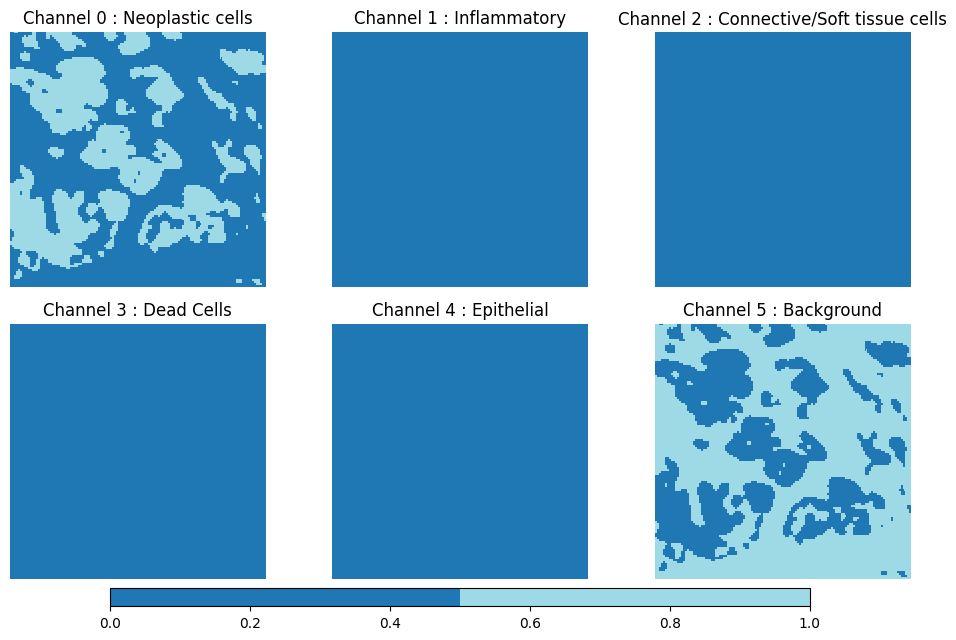

IoU: 0.7486537098884583
Dice: 0.5982786417007446
FocalLoss: 2.6004607677459717
19/19 [==============================] - 13s 731ms/step


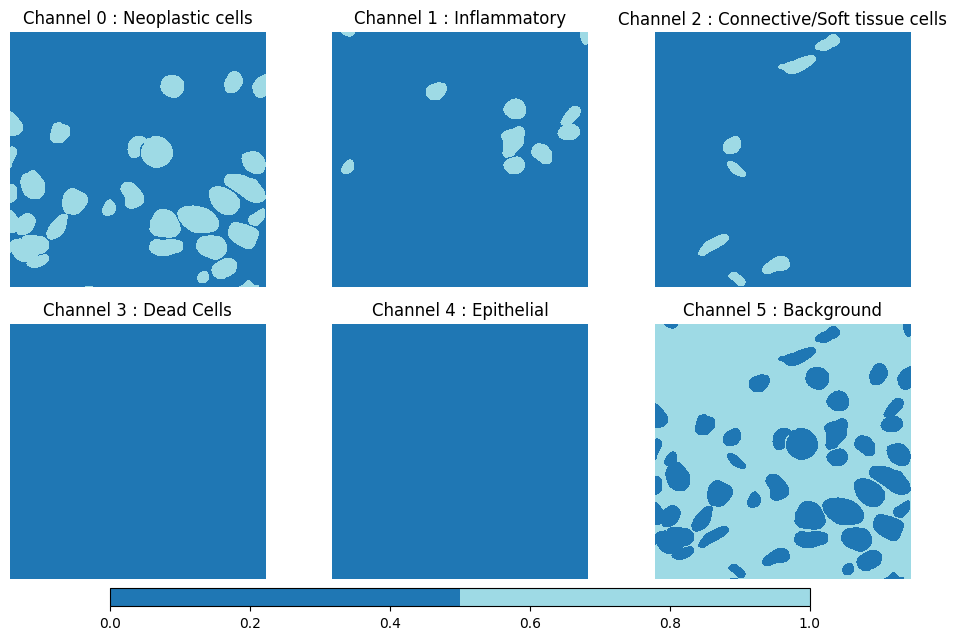

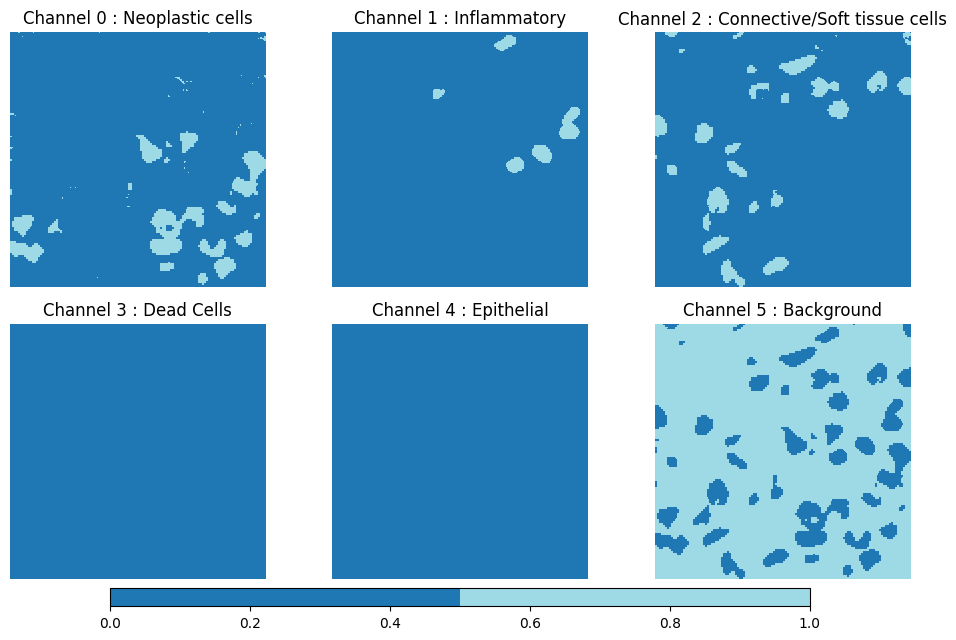

IoU: 0.7486537098884583
Dice: 0.5982786417007446
FocalLoss: 2.6004607677459717
19/19 [==============================] - 13s 735ms/step


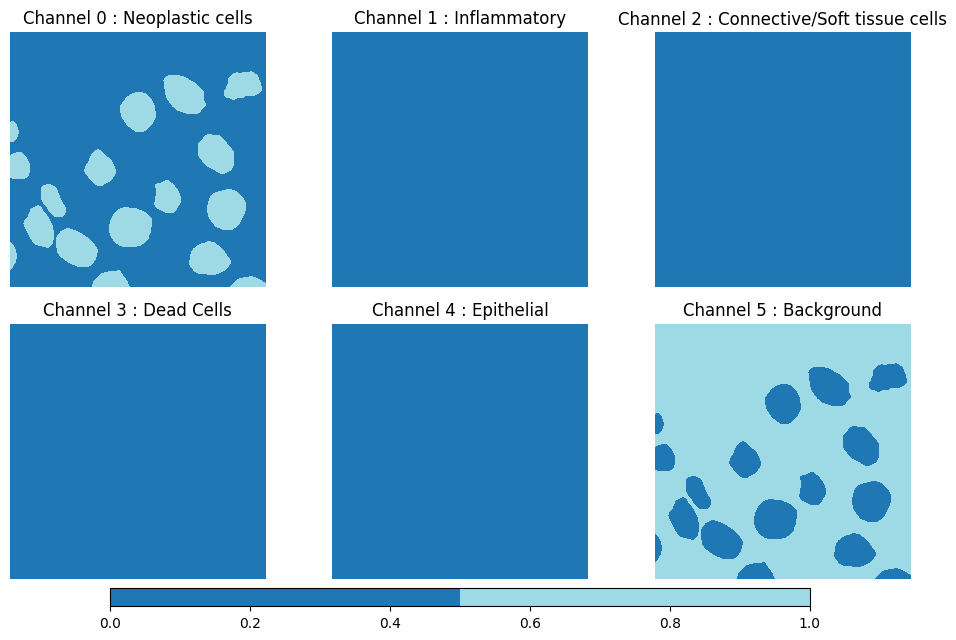

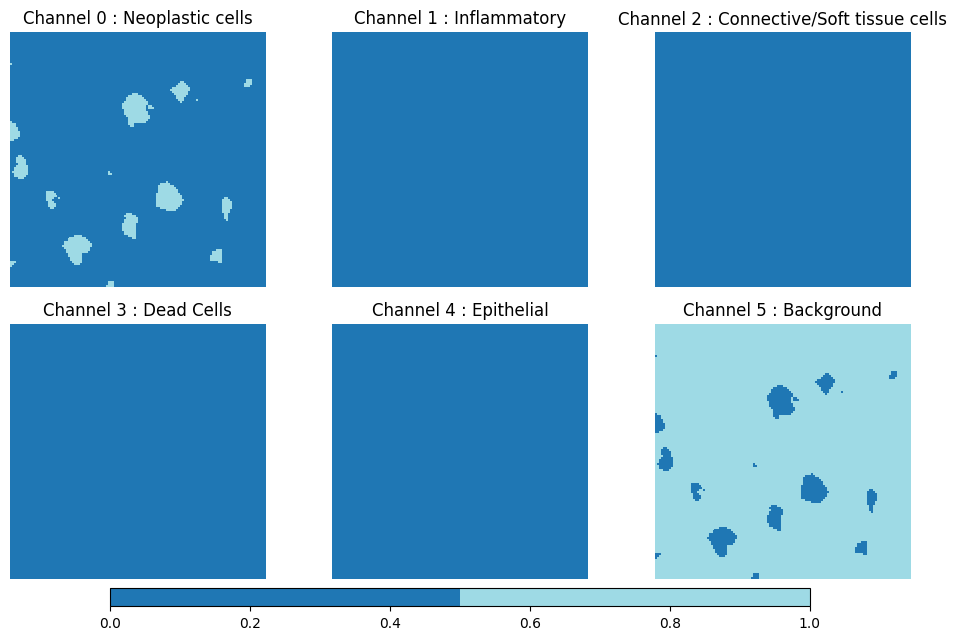

IoU: 0.7486537098884583
Dice: 0.5982786417007446
FocalLoss: 2.6004607677459717
19/19 [==============================] - 13s 737ms/step


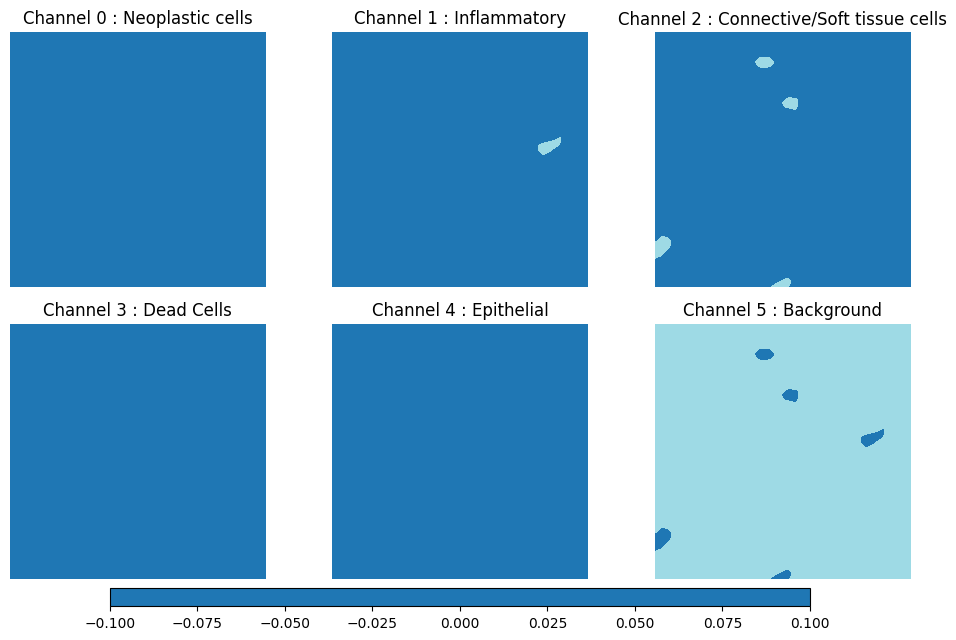

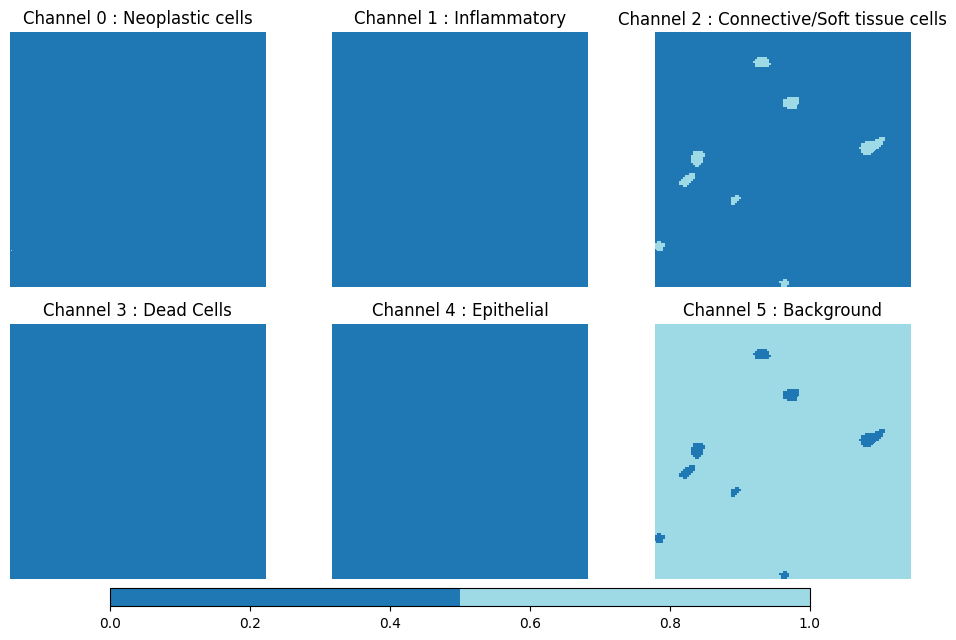

IoU: 0.7486537098884583
Dice: 0.5982786417007446
FocalLoss: 2.6004607677459717
19/19 [==============================] - 13s 739ms/step


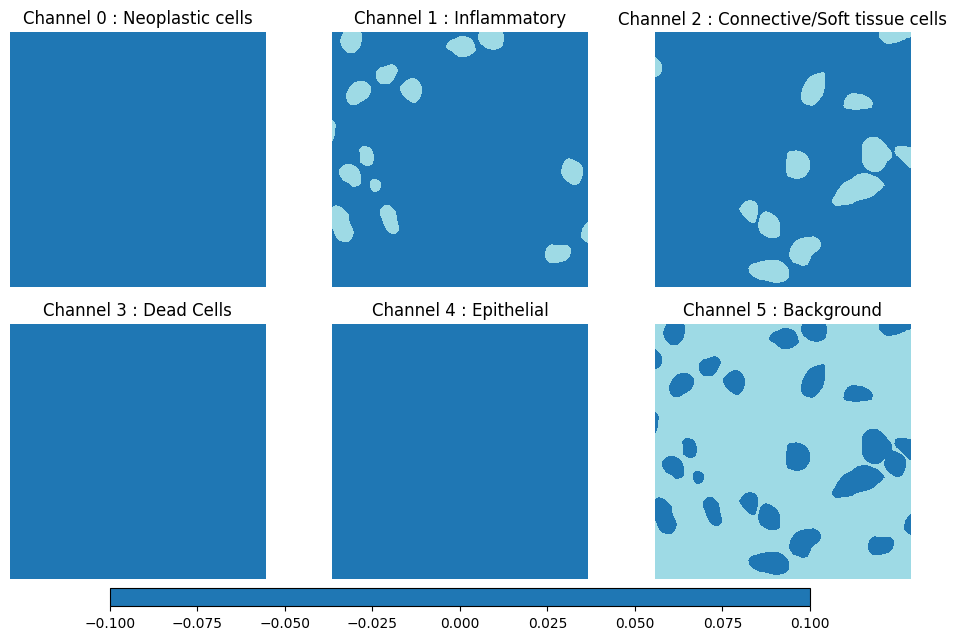

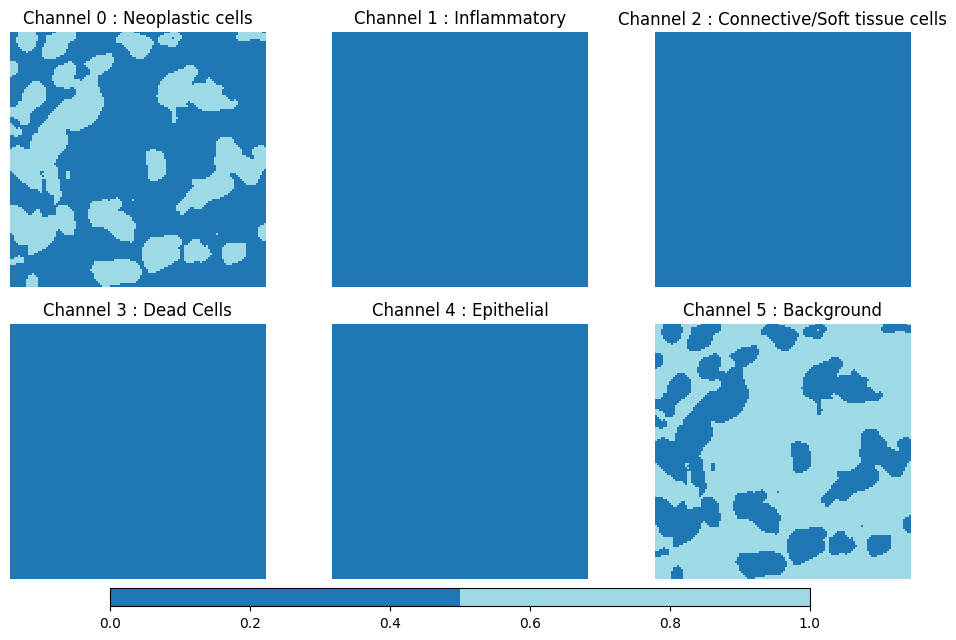

IoU: 0.7486537098884583
Dice: 0.5982786417007446
FocalLoss: 2.6004607677459717
19/19 [==============================] - 13s 740ms/step


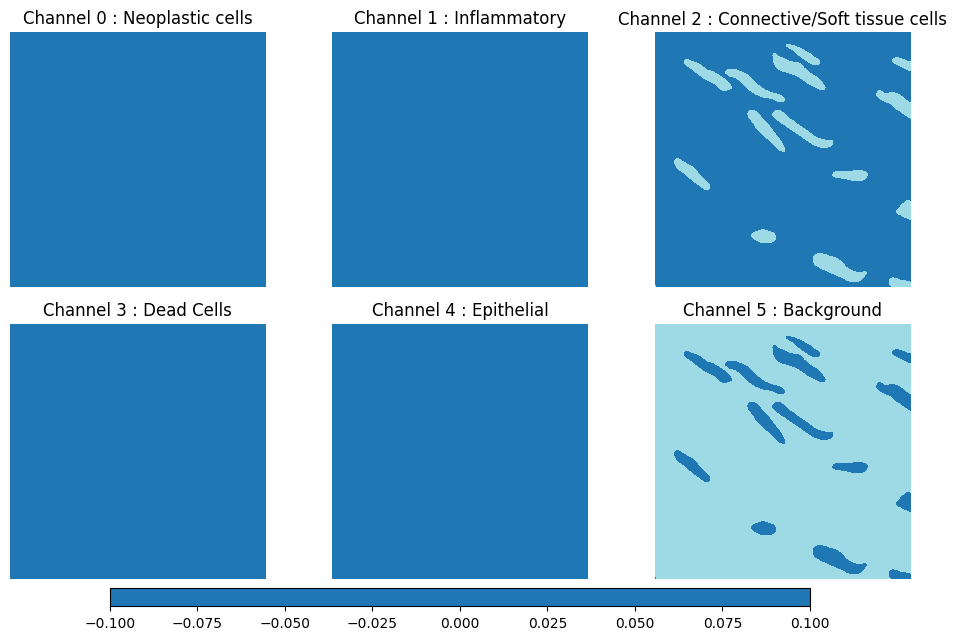

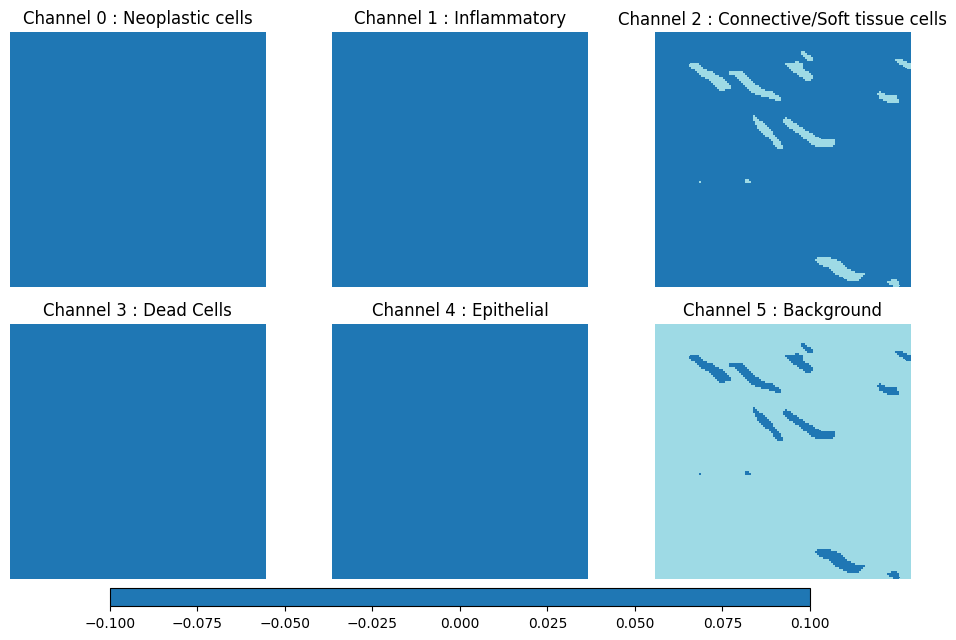

IoU: 0.7486537098884583
Dice: 0.5982786417007446
FocalLoss: 2.6004607677459717
19/19 [==============================] - 13s 740ms/step


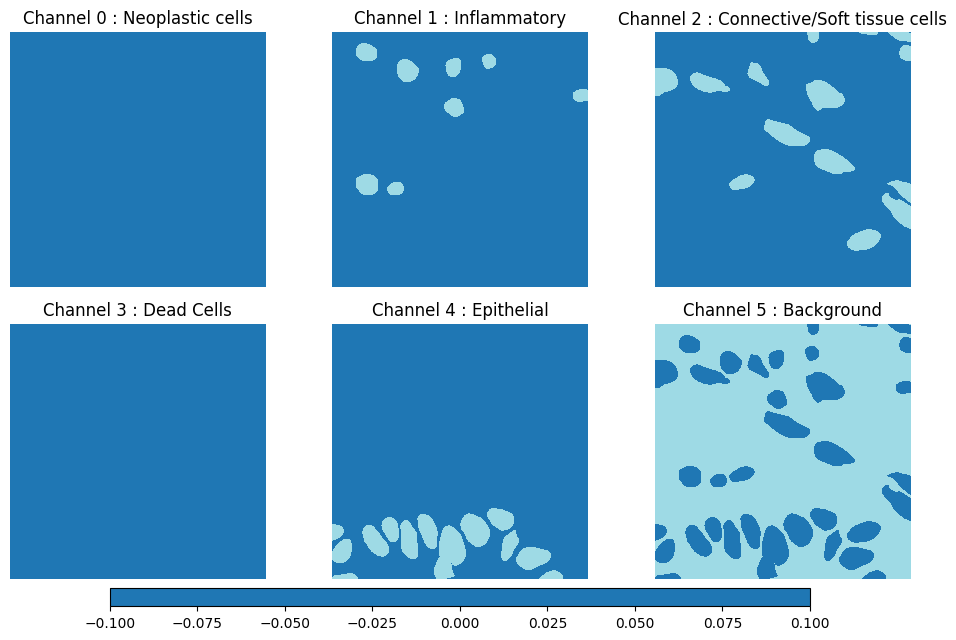

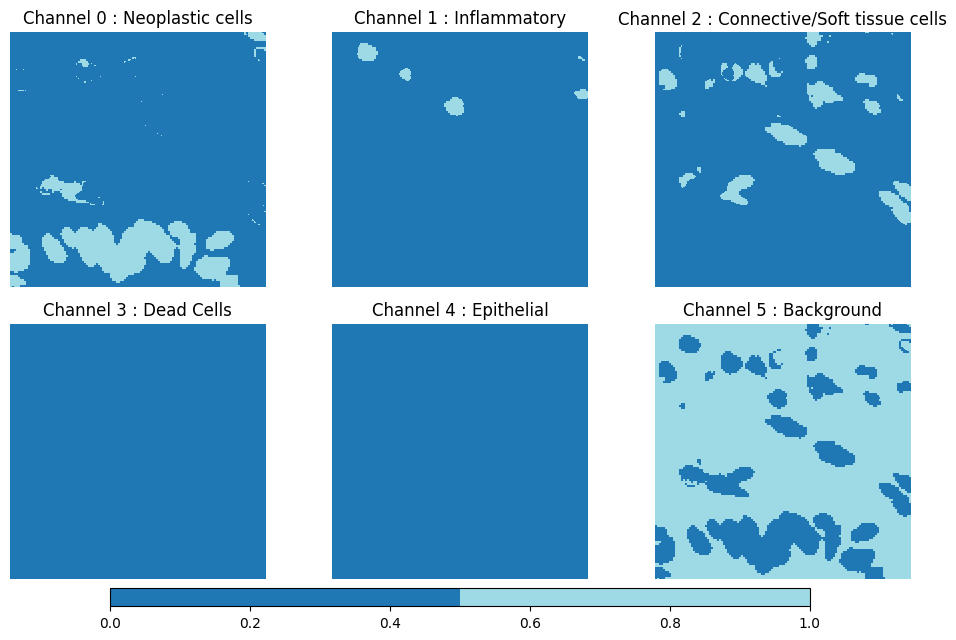

IoU: 0.7486537098884583
Dice: 0.5982786417007446
FocalLoss: 2.6004607677459717
19/19 [==============================] - 13s 740ms/step


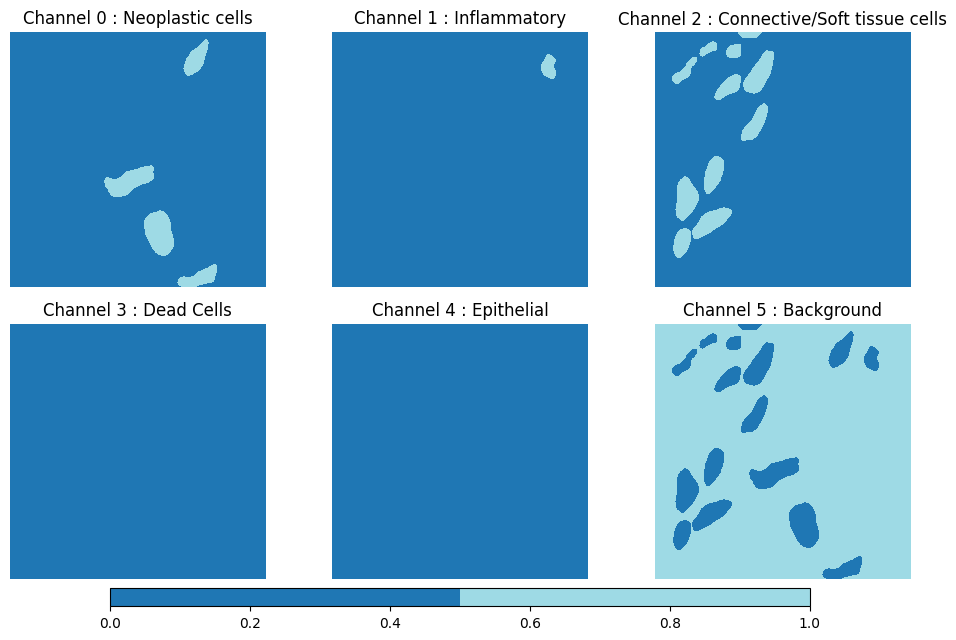

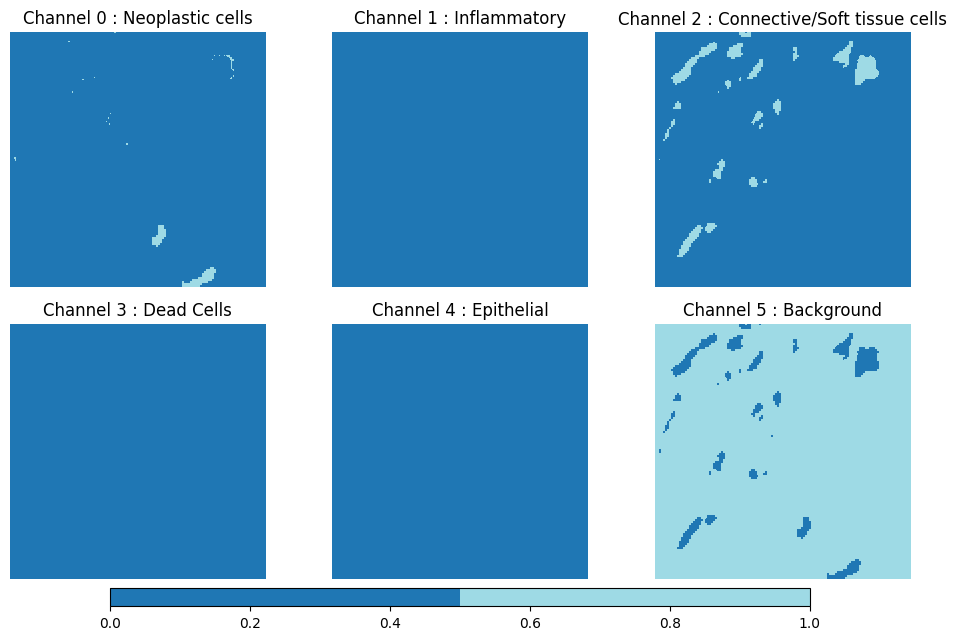

IoU: 0.7486537098884583
Dice: 0.5982786417007446
FocalLoss: 2.6004607677459717
19/19 [==============================] - 13s 741ms/step


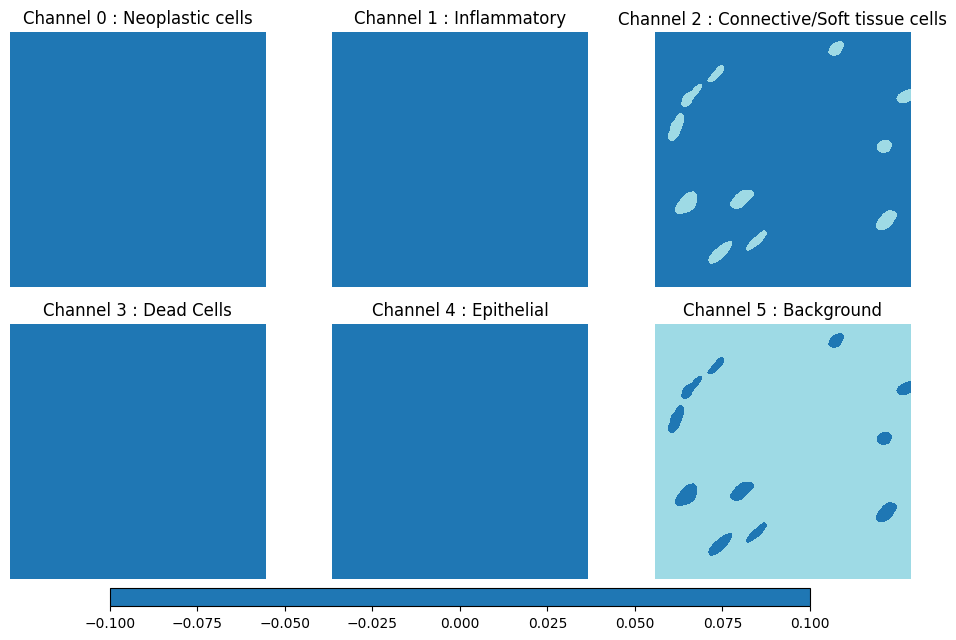

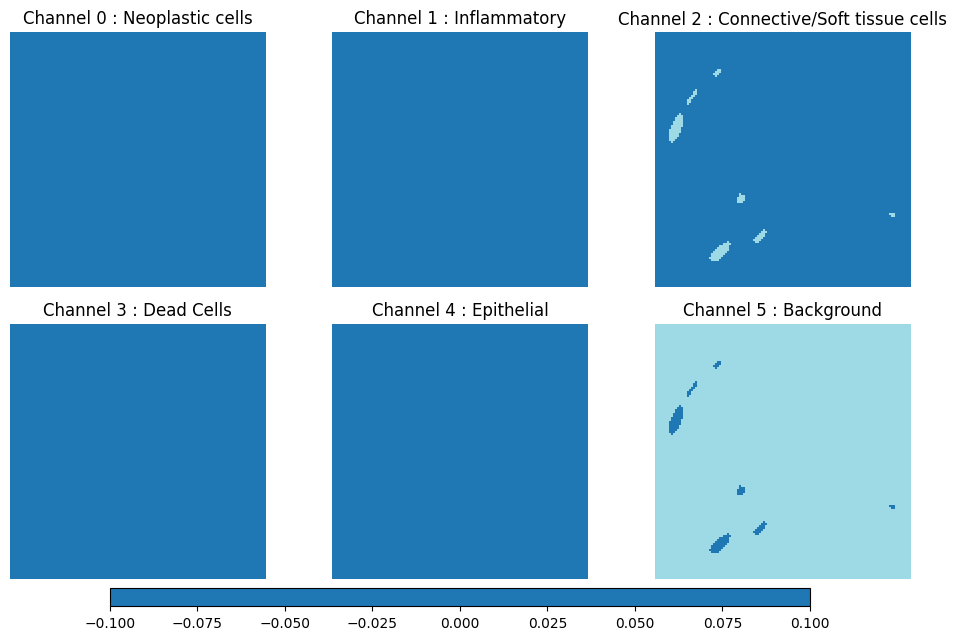

IoU: 0.7486537098884583
Dice: 0.5982786417007446
FocalLoss: 2.6004607677459717
19/19 [==============================] - 13s 741ms/step


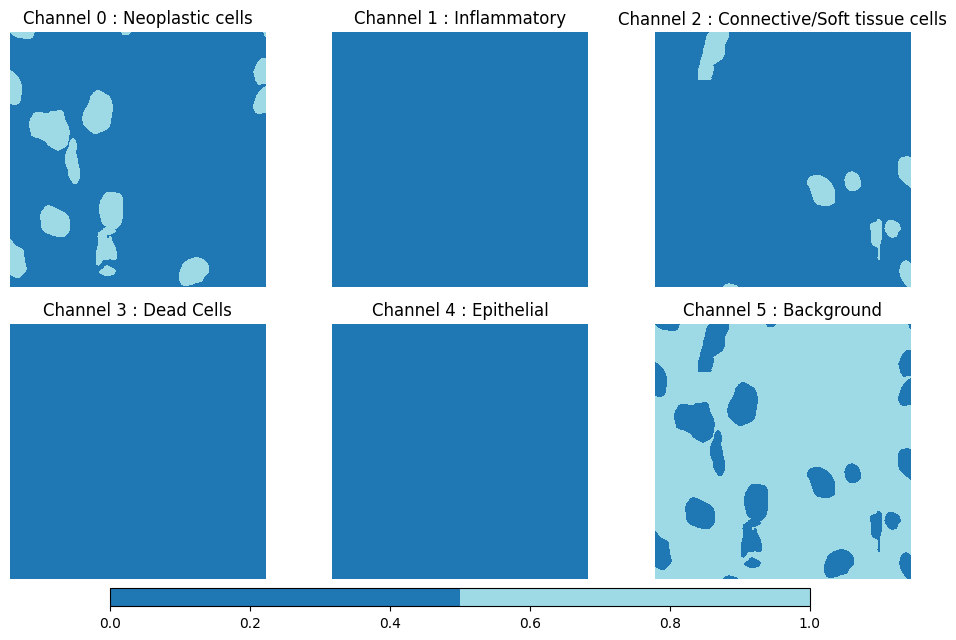

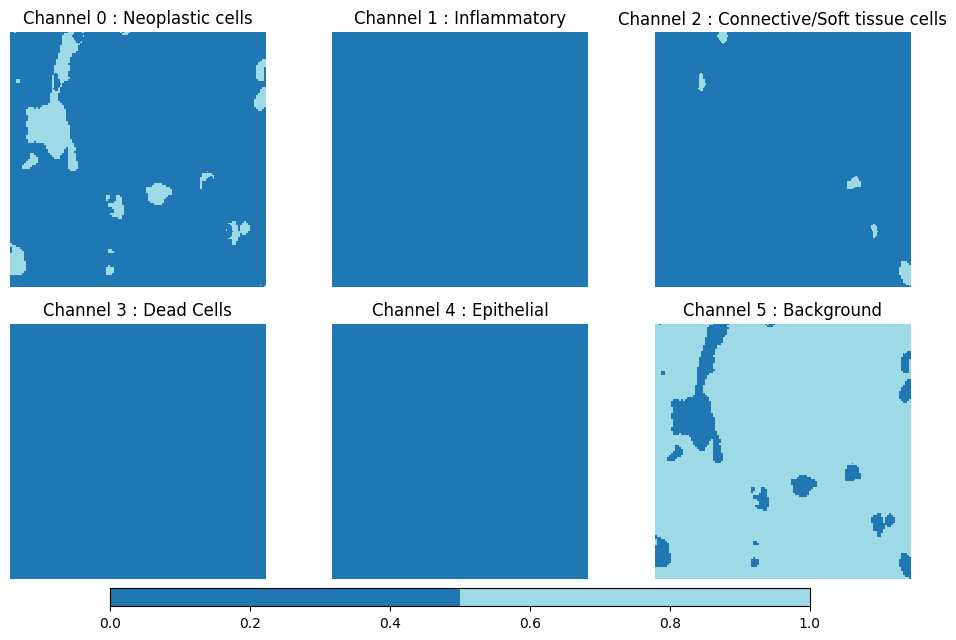

IoU: 0.7486537098884583
Dice: 0.5982786417007446
FocalLoss: 2.6004607677459717


In [56]:
for _ in range(10):
    predict(images = trainImages,
            target = trainMasks,
            model = model,
            idx = random.randint(0, trainImages.shape[0])
    )

### Test Results

In [57]:
testImages, testMasks = loadTest()

Processing Testing Masks: 100%|##########| 782/782 [00:01<00:00, 626.63it/s] 


25/25 [==============================] - 18s 737ms/step


/tmp/ipykernel_3351/2983828874.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20', int(max_value + 1))
/tmp/ipykernel_3351/2983828874.py:23: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


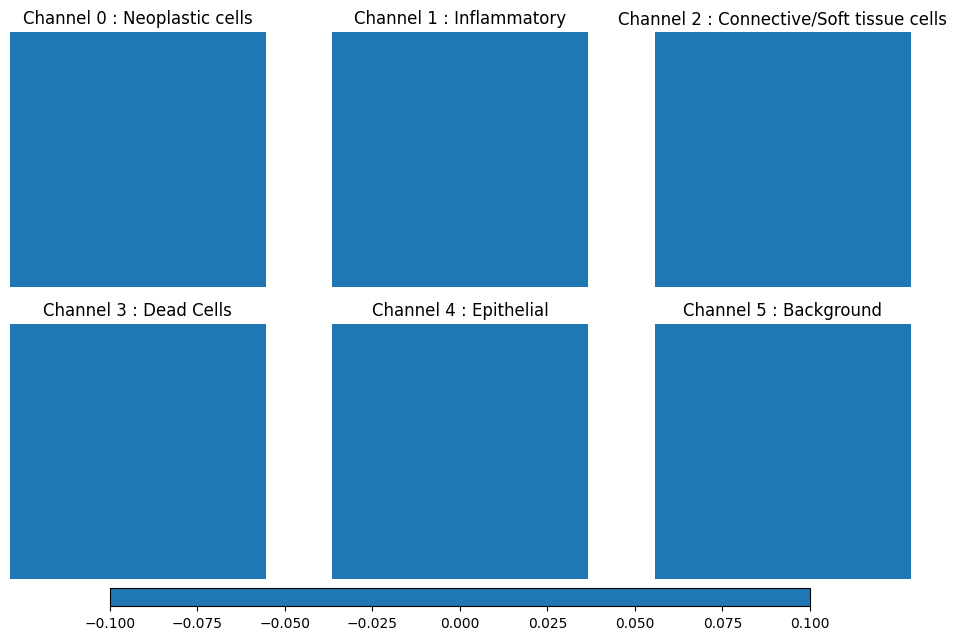

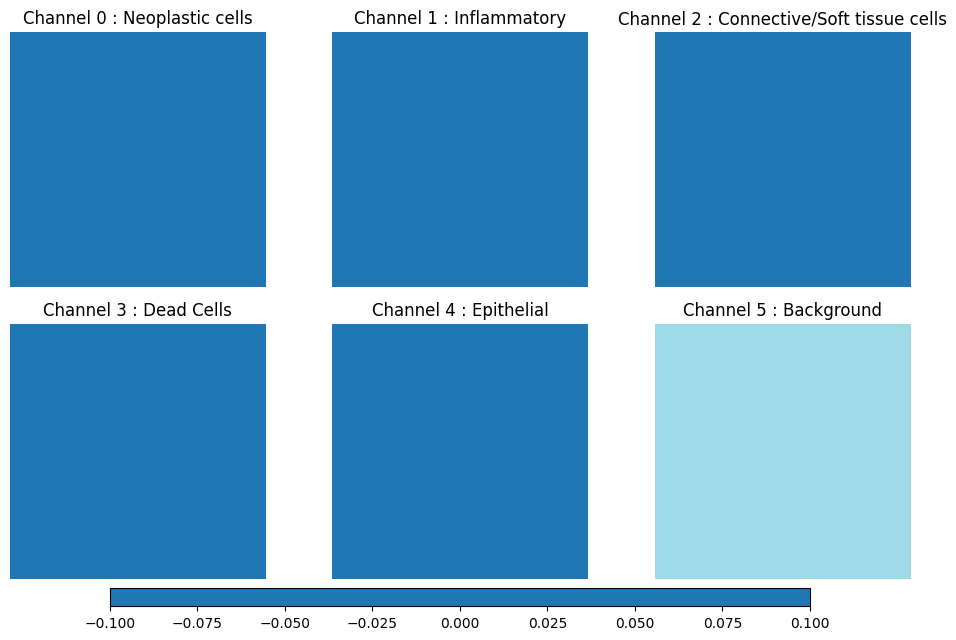

IoU: 0.7730846405029297
Dice: 0.6301043033599854
FocalLoss: 2.662790536880493
25/25 [==============================] - 18s 738ms/step


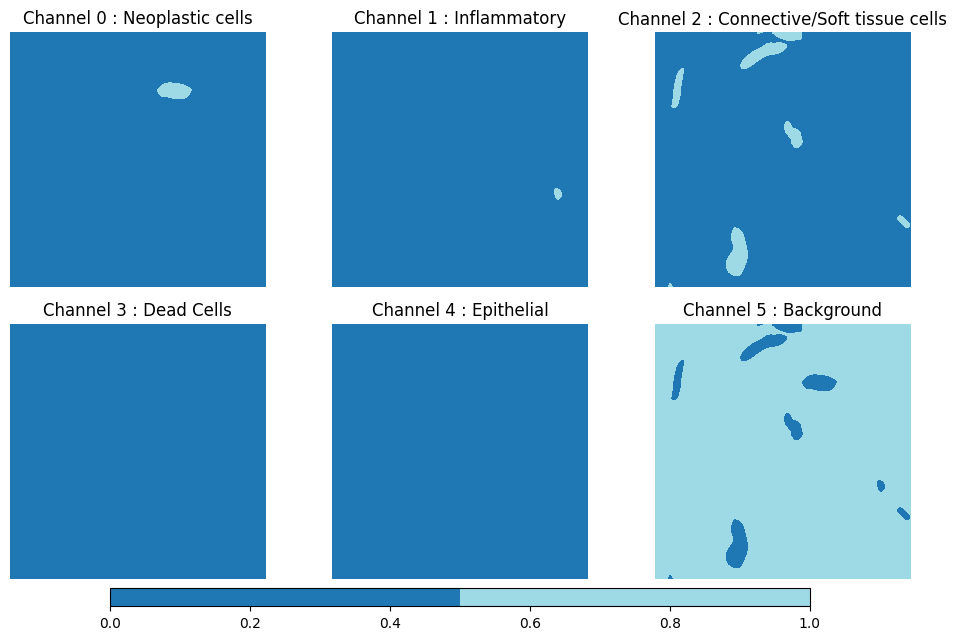

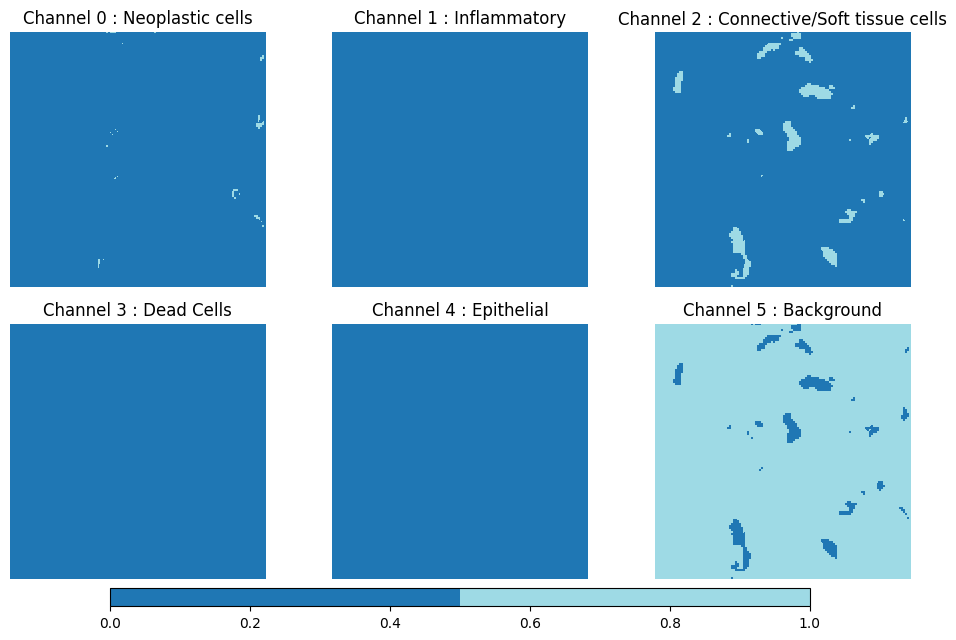

IoU: 0.7730846405029297
Dice: 0.6301043033599854
FocalLoss: 2.662790536880493
25/25 [==============================] - 18s 739ms/step


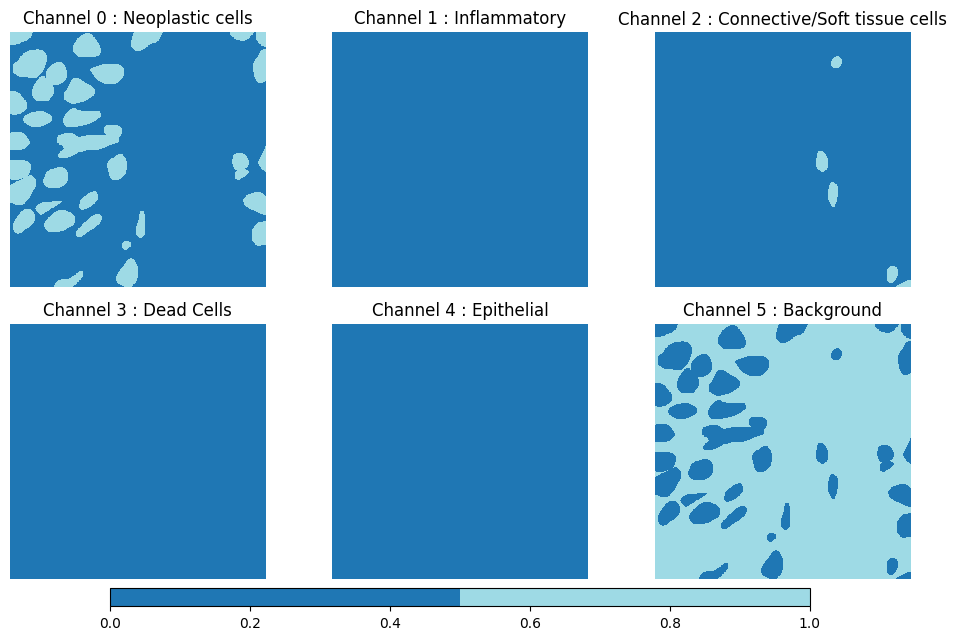

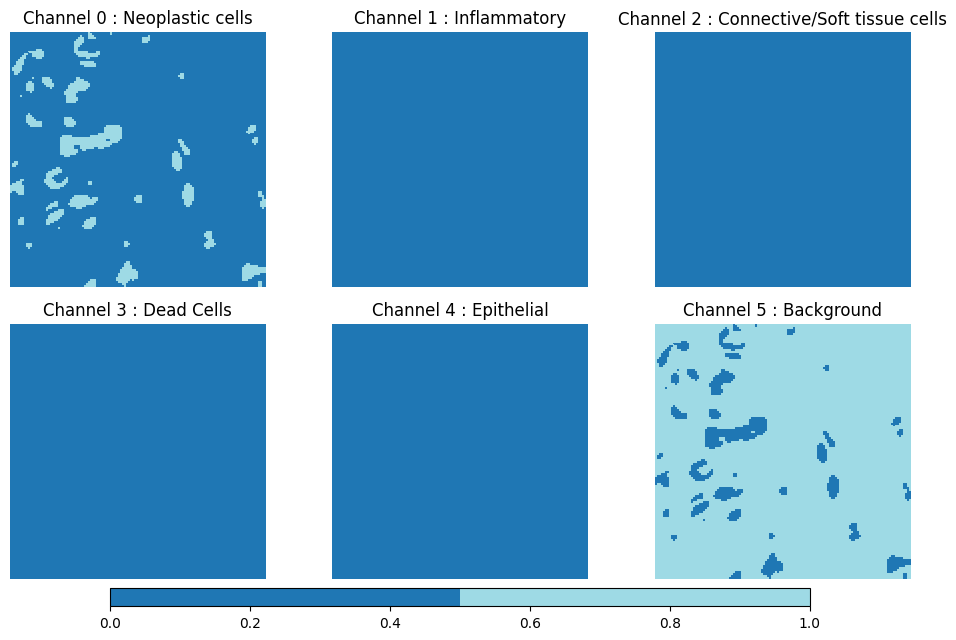

IoU: 0.7730846405029297
Dice: 0.6301043033599854
FocalLoss: 2.662790536880493
25/25 [==============================] - 18s 740ms/step


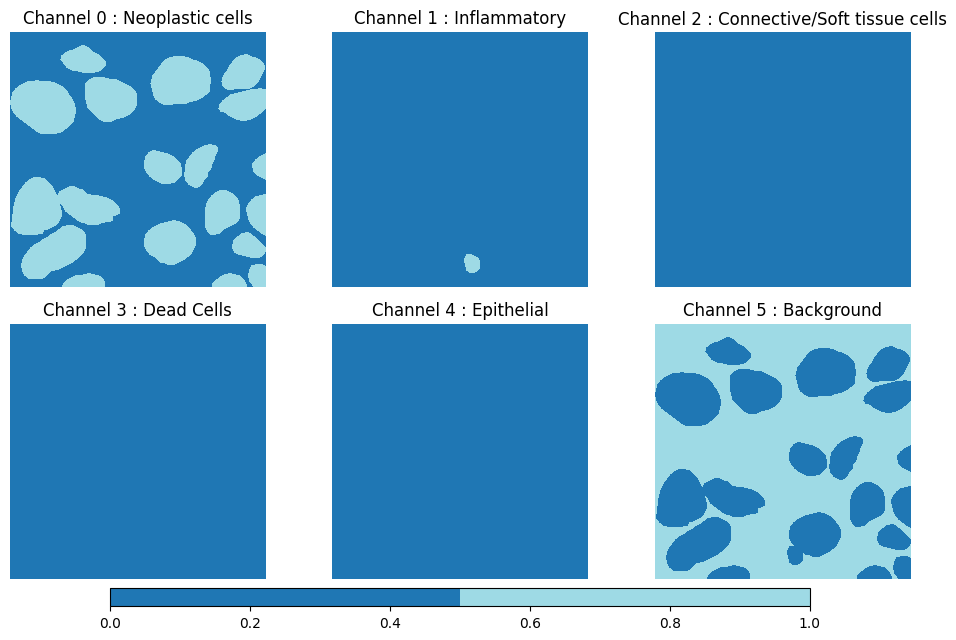

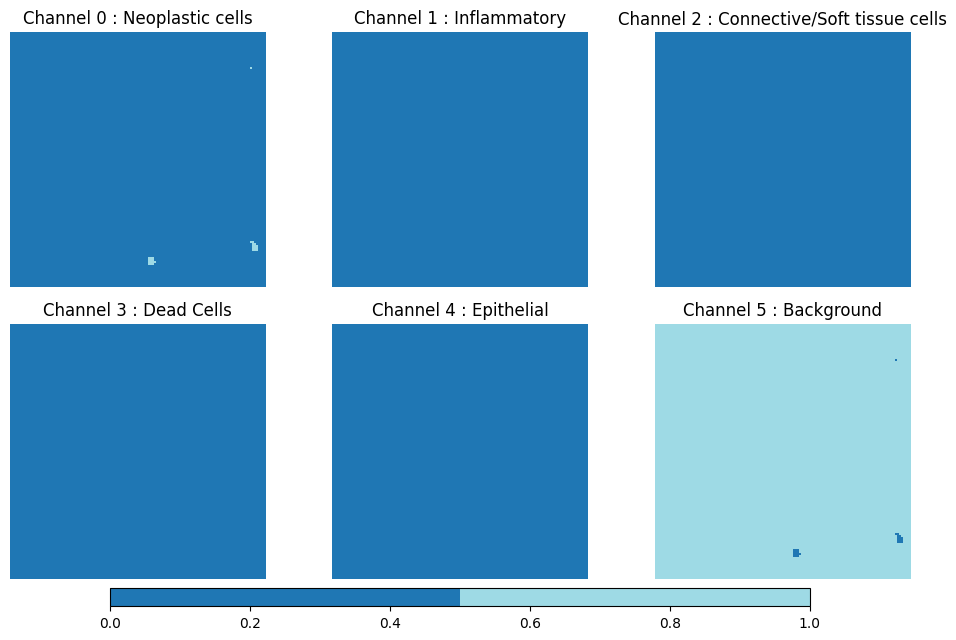

IoU: 0.7730846405029297
Dice: 0.6301043033599854
FocalLoss: 2.662790536880493
25/25 [==============================] - 18s 740ms/step


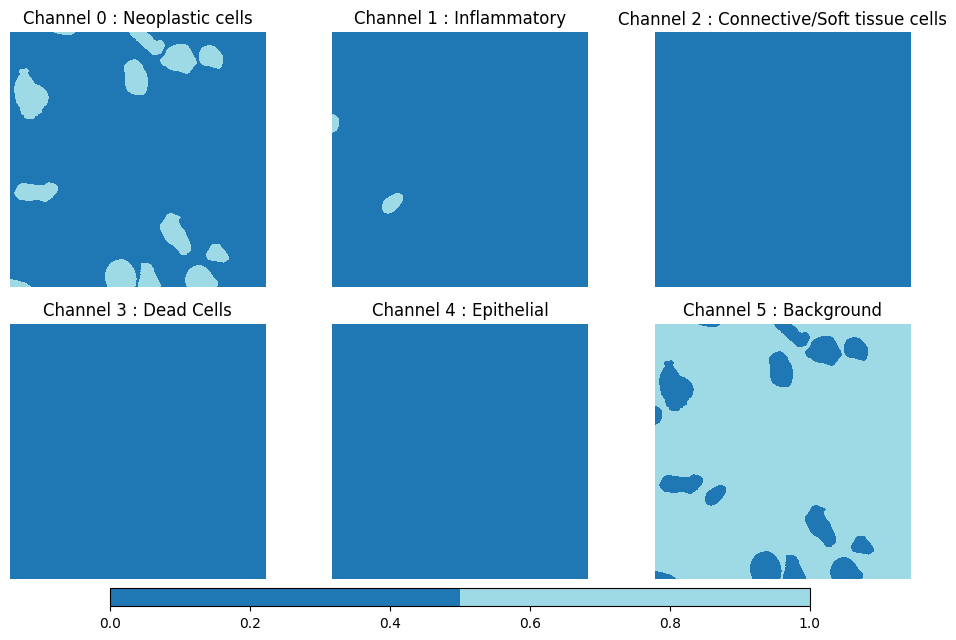

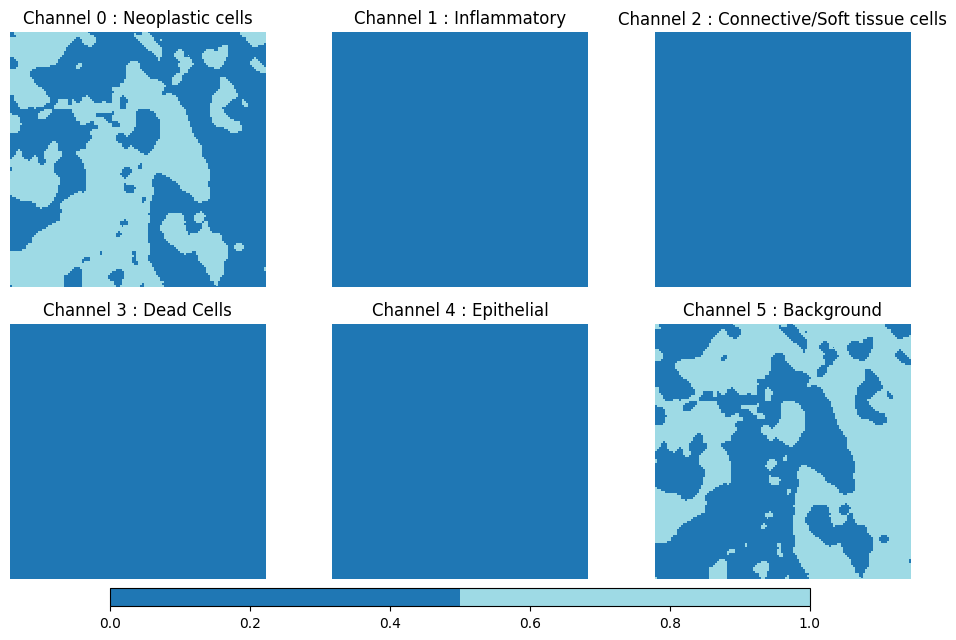

IoU: 0.7730846405029297
Dice: 0.6301043033599854
FocalLoss: 2.662790536880493
25/25 [==============================] - 18s 740ms/step


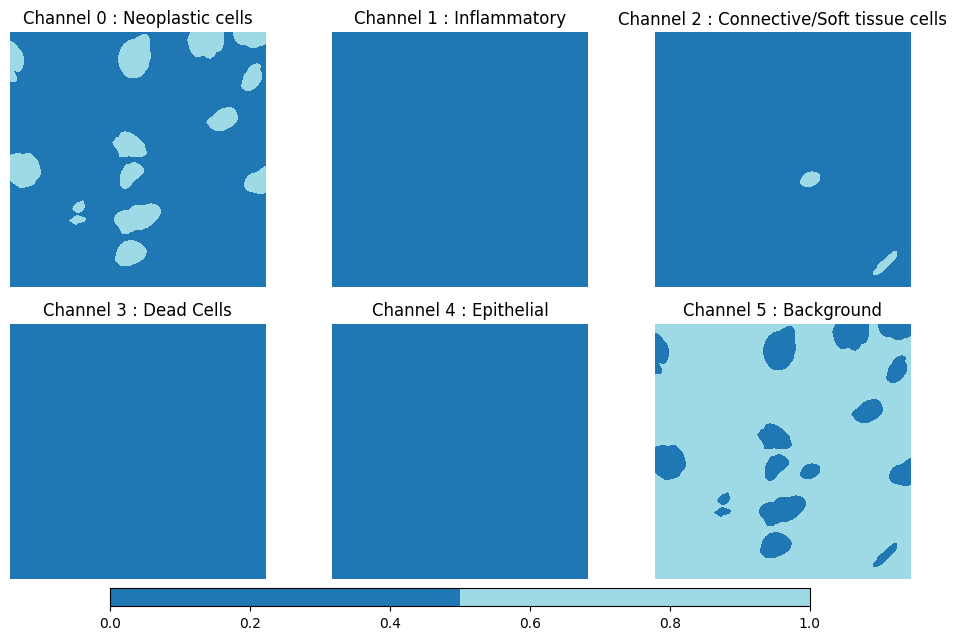

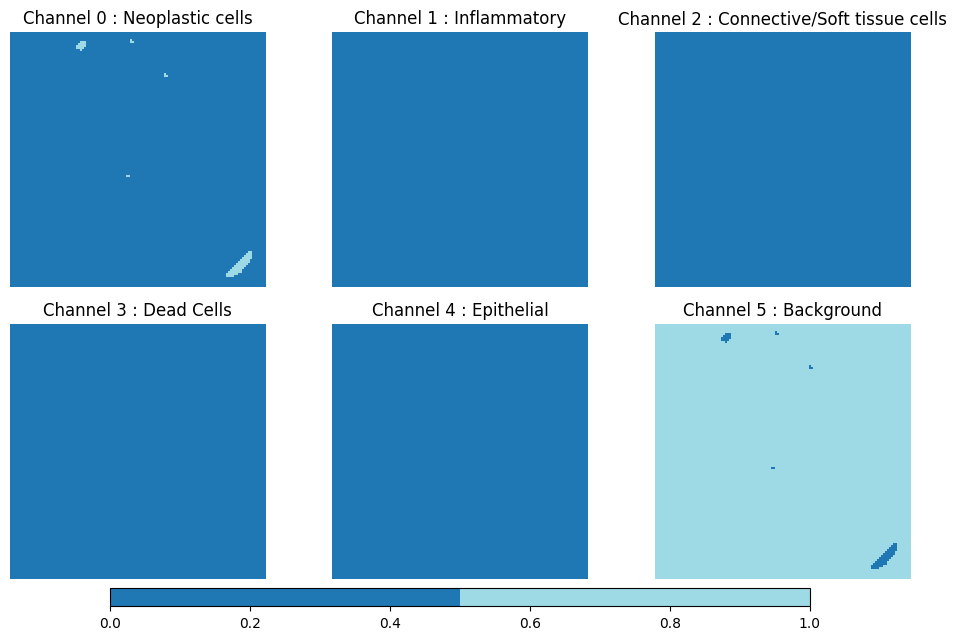

IoU: 0.7730846405029297
Dice: 0.6301043033599854
FocalLoss: 2.662790536880493
25/25 [==============================] - 18s 740ms/step


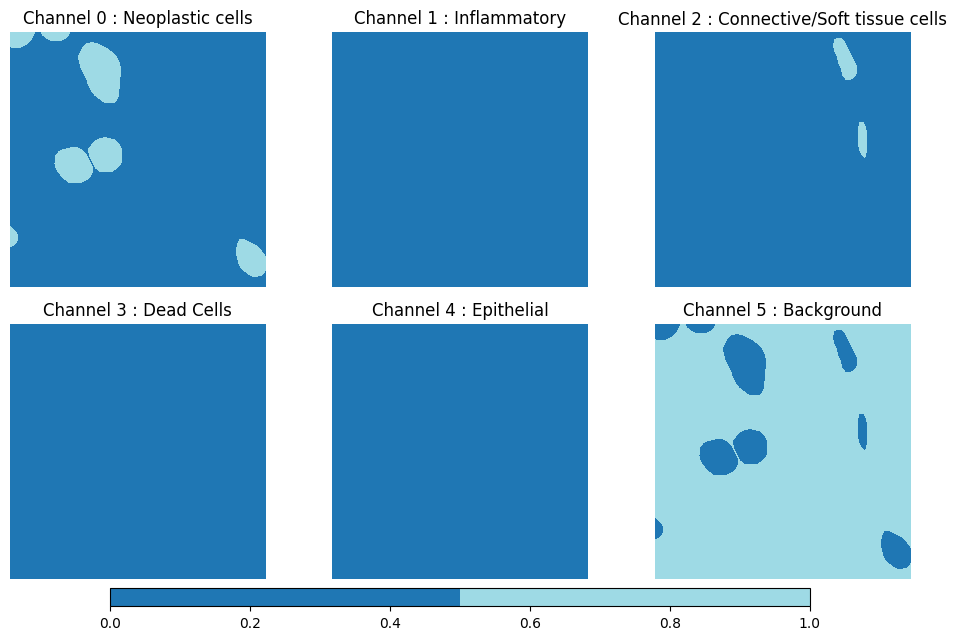

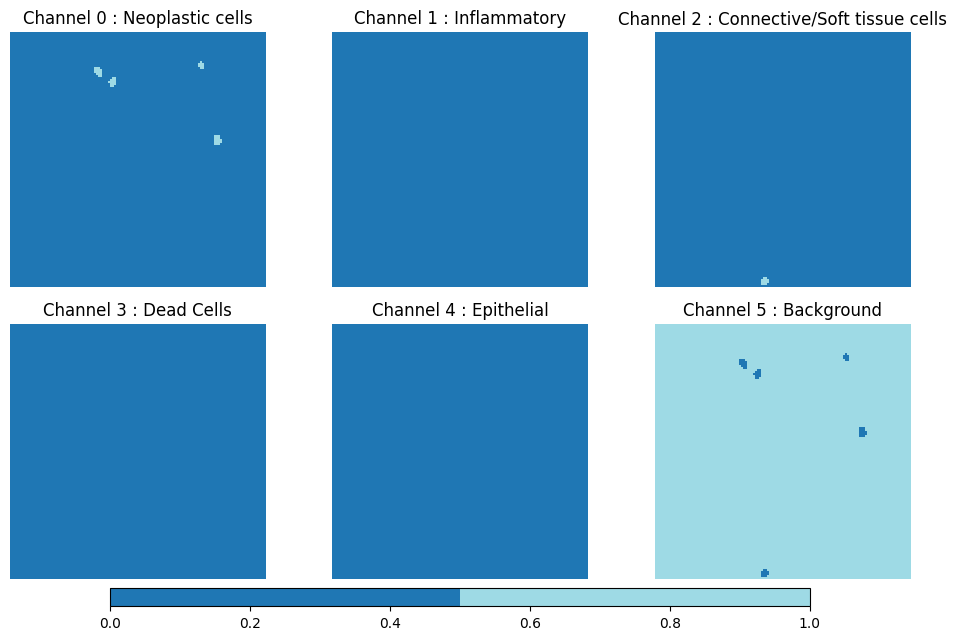

IoU: 0.7730846405029297
Dice: 0.6301043033599854
FocalLoss: 2.662790536880493
25/25 [==============================] - 18s 740ms/step


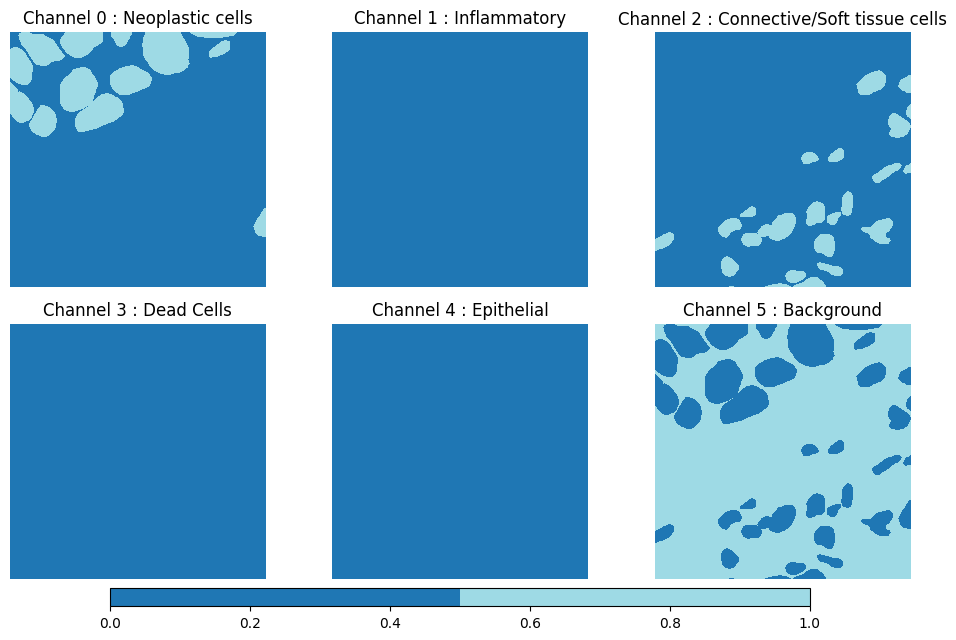

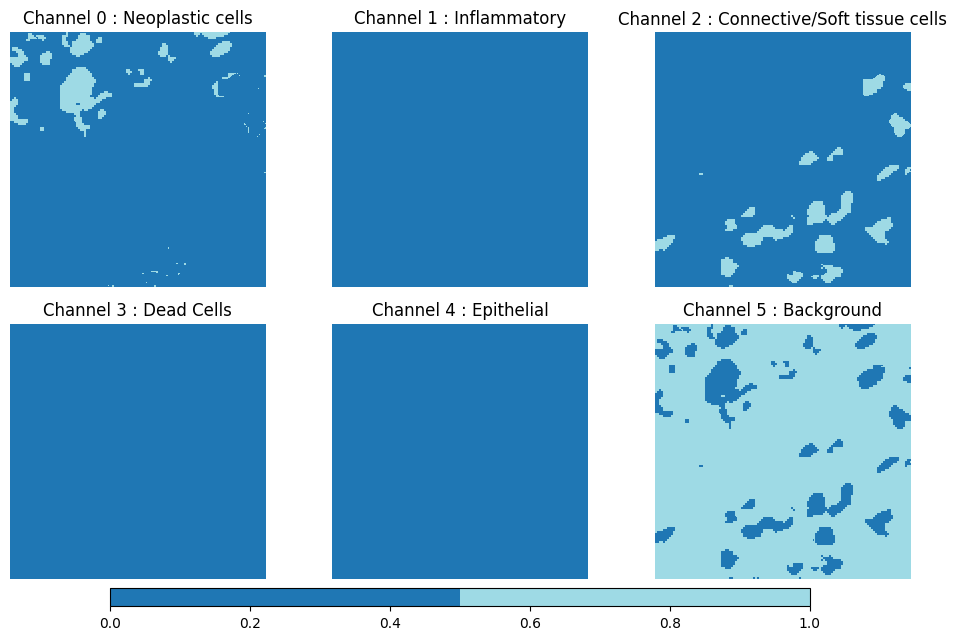

IoU: 0.7730846405029297
Dice: 0.6301043033599854
FocalLoss: 2.662790536880493
25/25 [==============================] - 18s 740ms/step


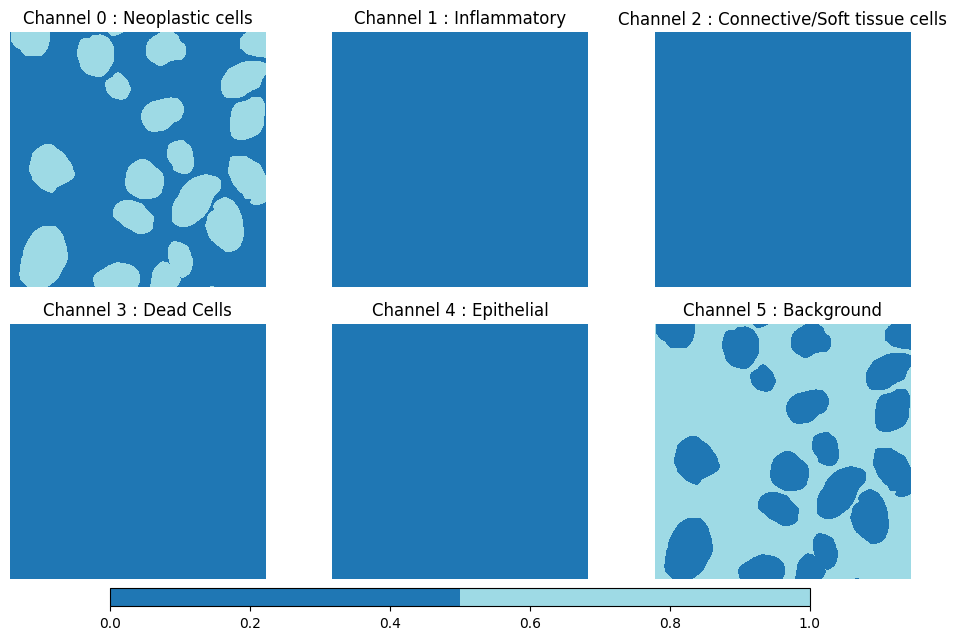

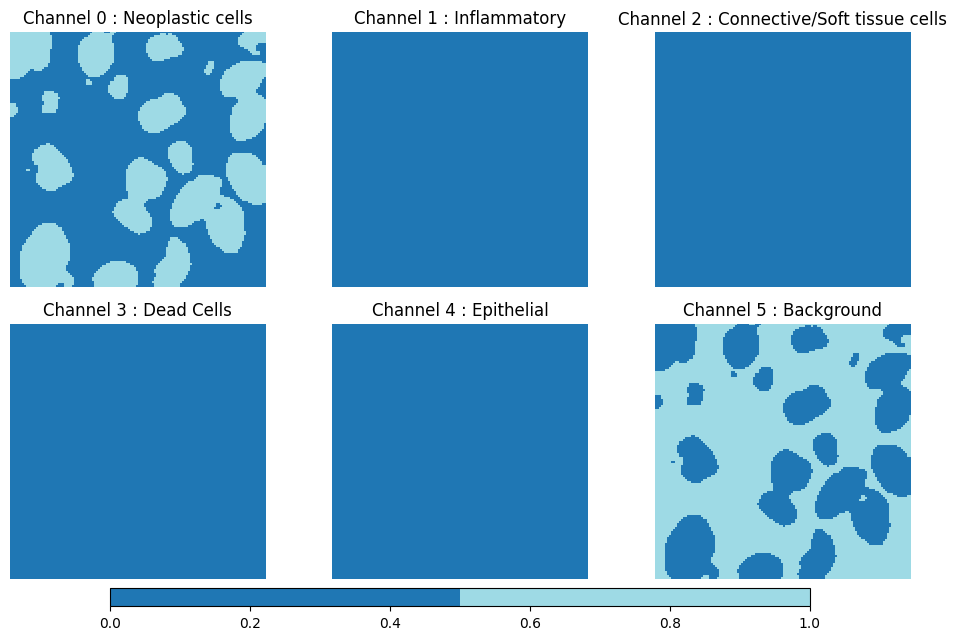

IoU: 0.7730846405029297
Dice: 0.6301043033599854
FocalLoss: 2.662790536880493
25/25 [==============================] - 18s 741ms/step


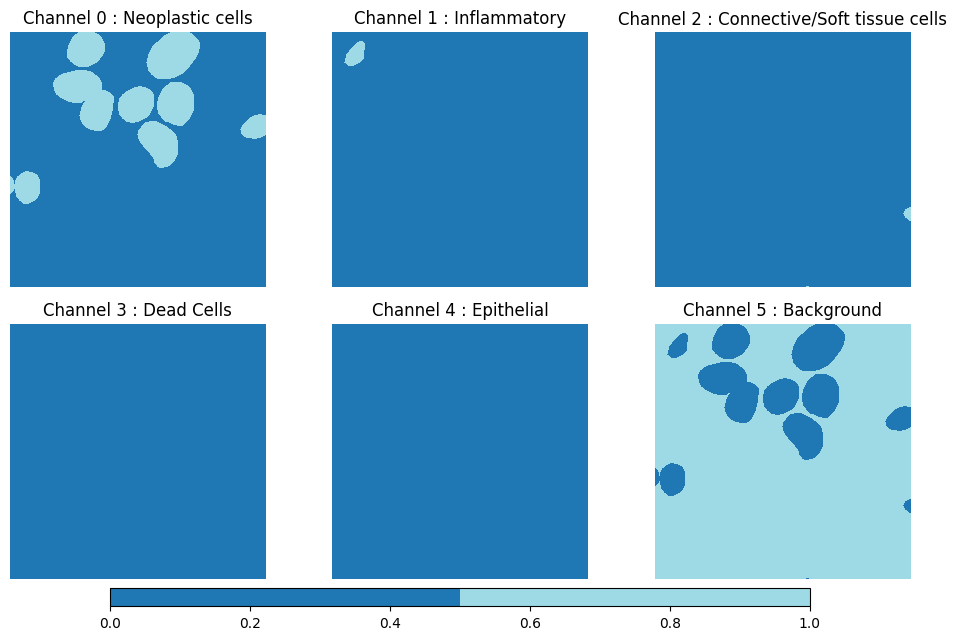

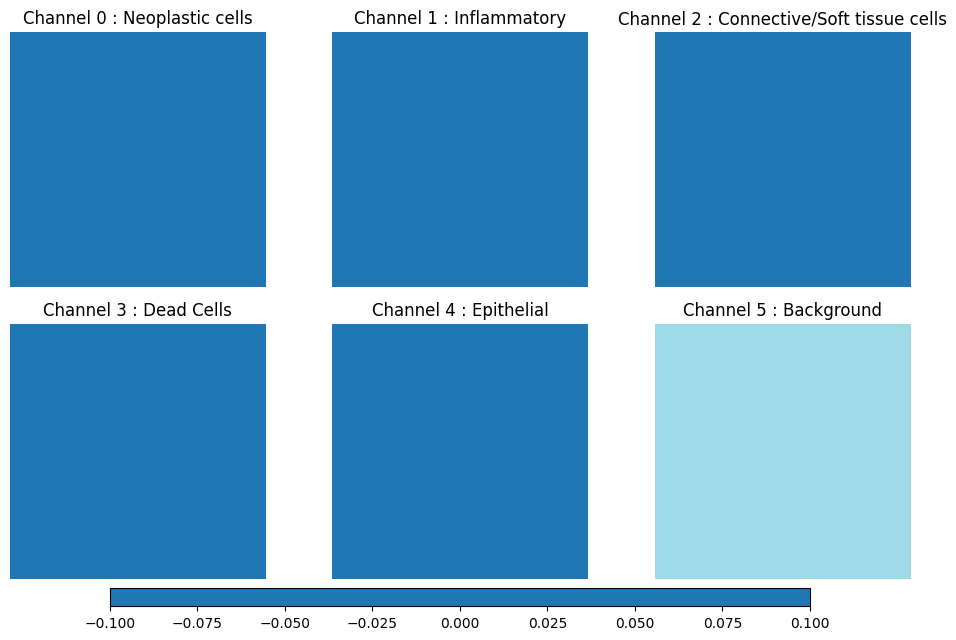

IoU: 0.7730846405029297
Dice: 0.6301043033599854
FocalLoss: 2.662790536880493


In [58]:
for _ in range(10):
    predict(images = testImages,
            target = testMasks,
            model = model,
            idx = random.randint(0, trainImages.shape[0])
    )